# Stock Trend Prediction Using Machine Learning Classification

## 1. Introduction and Problem Statement

### Problem Definition
This project addresses the challenge of **predicting 6-month stock price trends** using machine learning classification techniques. We frame this as a **supervised binary classification problem** where we predict whether a stock's price will trend upward or downward over the next 6 months.

### Stock Selection Rationale
We selected 15 stocks representing diverse market sectors:
- **Technology**: AAPL, MSFT, NVDA, GOOGL, AMD (innovation-driven, high volatility)
- **Finance**: JPM, BAC (economic indicators, cyclical patterns)
- **Healthcare**: UNH, JNJ (defensive, stable growth)
- **Energy**: XOM (commodity-driven, inflation hedge)
- **Consumer Goods**: PG, HD (consumer sentiment indicators)
- **Media/Industrial**: DIS, GE, BA (diversified operations)

**Generalization Benefits**: This diversified portfolio captures different market dynamics, economic sensitivities, and volatility profiles, making our model more generalizable to broader market conditions rather than sector-specific patterns.

### Objectives
1. Build and compare 12 different ML models for trend prediction
2. Engineer relevant technical indicators and features
3. Evaluate model performance using appropriate classification metrics
4. Identify the best-performing model(s) for stock trend prediction

## 2. Environment Setup and Data Loading

In [1]:
# Import required libraries
import warnings
warnings.filterwarnings('ignore')

# Data manipulation and analysis
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Data acquisition
import yfinance as yf

# Technical indicators
import pandas_ta as ta

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

# Sklearn - preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer

# Sklearn - models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, StackingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

# Sklearn - metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)

# Deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Set random seeds for reproducibility
np.random.seed(50)
tf.random.set_seed(52)

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"Pandas version: {pd.__version__}")

Libraries imported successfully!
TensorFlow version: 2.16.2
Pandas version: 2.3.3


In [2]:
# Define stock symbols
STOCK_SYMBOLS = ['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'AMD', 'JPM', 'BAC', 
                 'UNH', 'JNJ', 'XOM', 'PG', 'HD', 'DIS', 'GE', 'BA']

# Define time period (last 5 years)
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print(f"Loading data for {len(STOCK_SYMBOLS)} stocks")
print(f"Date range: {start_date.date()} to {end_date.date()}")

Loading data for 15 stocks
Date range: 2020-12-03 to 2025-12-02


In [3]:
# Load stock data with error handling
def load_stock_data(symbols, start, end):
    """
    Load historical stock data for given symbols.
    
    Parameters:
    - symbols: list of stock ticker symbols
    - start: start date
    - end: end date
    
    Returns:
    - DataFrame with stock data
    """
    all_data = []
    
    for symbol in symbols:
        try:
            # Download data
            df = yf.download(symbol, start=start, end=end, progress=False)
            
            if df.empty:
                print(f"Warning: No data retrieved for {symbol}")
                continue
            
            # Add symbol column
            df['Symbol'] = symbol
            df = df.reset_index()
            
            all_data.append(df)
            print(f"✓ Loaded {len(df)} records for {symbol}")
            
        except Exception as e:
            print(f"Error loading {symbol}: {str(e)}")
    
    # Combine all data
    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
        return combined_df
    else:
        raise ValueError("No data could be loaded for any symbol")

# Load the data
raw_data = load_stock_data(STOCK_SYMBOLS, start_date, end_date)
print(f"\nTotal records loaded: {len(raw_data):,}")
print(f"Date range in data: {raw_data['Date'].min()} to {raw_data['Date'].max()}")

YF.download() has changed argument auto_adjust default to True
✓ Loaded 1254 records for AAPL
✓ Loaded 1254 records for MSFT
✓ Loaded 1254 records for NVDA
✓ Loaded 1254 records for GOOGL
✓ Loaded 1254 records for AMD
✓ Loaded 1254 records for JPM
✓ Loaded 1254 records for BAC
✓ Loaded 1254 records for UNH
✓ Loaded 1254 records for JNJ
✓ Loaded 1254 records for XOM
✓ Loaded 1254 records for PG
✓ Loaded 1254 records for HD
✓ Loaded 1254 records for DIS
✓ Loaded 1254 records for GE
✓ Loaded 1254 records for BA

Total records loaded: 18,810
Date range in data: 2020-12-04 00:00:00 to 2025-12-02 00:00:00


In [4]:
# Display initial data structure
print("Data Structure:")
print(f"Shape: {raw_data.shape}")
print(f"\nColumns: {list(raw_data.columns)}")
print(f"\nData types:")
print(raw_data.dtypes)
print(f"\nFirst few rows:")
raw_data.head(10)

Data Structure:
Shape: (18810, 77)

Columns: [('Date', ''), ('Close', 'AAPL'), ('High', 'AAPL'), ('Low', 'AAPL'), ('Open', 'AAPL'), ('Volume', 'AAPL'), ('Symbol', ''), ('Close', 'MSFT'), ('High', 'MSFT'), ('Low', 'MSFT'), ('Open', 'MSFT'), ('Volume', 'MSFT'), ('Close', 'NVDA'), ('High', 'NVDA'), ('Low', 'NVDA'), ('Open', 'NVDA'), ('Volume', 'NVDA'), ('Close', 'GOOGL'), ('High', 'GOOGL'), ('Low', 'GOOGL'), ('Open', 'GOOGL'), ('Volume', 'GOOGL'), ('Close', 'AMD'), ('High', 'AMD'), ('Low', 'AMD'), ('Open', 'AMD'), ('Volume', 'AMD'), ('Close', 'JPM'), ('High', 'JPM'), ('Low', 'JPM'), ('Open', 'JPM'), ('Volume', 'JPM'), ('Close', 'BAC'), ('High', 'BAC'), ('Low', 'BAC'), ('Open', 'BAC'), ('Volume', 'BAC'), ('Close', 'UNH'), ('High', 'UNH'), ('Low', 'UNH'), ('Open', 'UNH'), ('Volume', 'UNH'), ('Close', 'JNJ'), ('High', 'JNJ'), ('Low', 'JNJ'), ('Open', 'JNJ'), ('Volume', 'JNJ'), ('Close', 'XOM'), ('High', 'XOM'), ('Low', 'XOM'), ('Open', 'XOM'), ('Volume', 'XOM'), ('Close', 'PG'), ('High', 'PG

Price,Date,Close,High,Low,Open,Volume,Symbol,Close,High,Low,...,Close,High,Low,Open,Volume,Close,High,Low,Open,Volume
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL,,MSFT,MSFT,MSFT,...,GE,GE,GE,GE,GE,BA,BA,BA,BA,BA
0,2020-12-04,119.004532,119.598338,118.293908,119.345239,78260400.0,AAPL,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-12-07,120.464722,121.262952,119.004543,119.062948,86712000.0,AAPL,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-12-08,121.078003,121.662080,119.822248,121.068274,82225500.0,AAPL,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-12-09,118.547028,122.606322,117.787736,121.224022,115089200.0,AAPL,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-12-10,119.968262,120.581541,116.960298,117.301004,81312200.0,AAPL,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2020-12-11,119.160301,119.501008,117.349679,119.179767,86939800.0,AAPL,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2020-12-14,118.547028,120.075348,118.313401,119.345258,79184500.0,AAPL,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2020-12-15,124.485092,124.504565,120.834646,121.039070,157243700.0,AAPL,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2020-12-16,124.416954,124.962085,123.200138,124.027579,98208600.0,AAPL,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Basic statistics
print("Basic Statistics:")
raw_data.describe()

Basic Statistics:


Price,Date,Close,High,Low,Open,Volume,Close,High,Low,Open,...,Close,High,Low,Open,Volume,Close,High,Low,Open,Volume
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL,MSFT,MSFT,MSFT,MSFT,...,GE,GE,GE,GE,GE,BA,BA,BA,BA,BA
count,18810,1254.000000,1254.000000,1254.000000,1254.000000,1.254000e+03,1254.000000,1254.000000,1254.000000,1254.000000,...,1254.000000,1254.000000,1254.000000,1254.000000,1.254000e+03,1254.000000,1254.000000,1254.000000,1254.000000,1.254000e+03
mean,2023-06-03 23:33:35.311004928,177.178566,178.933753,175.239019,176.987608,7.082984e+07,338.462279,341.508006,335.141240,338.408309,...,115.453864,116.787549,113.984075,115.355580,8.685476e+06,196.070032,198.902480,193.392337,196.126507,9.018569e+06
min,2020-12-04 00:00:00,113.440178,117.378803,113.293940,116.043177,2.013560e+07,202.002304,204.458723,200.649385,201.551355,...,37.443462,37.486365,36.732467,37.388299,1.376400e+06,115.860001,122.190002,113.019997,116.650002,2.143000e+06
25%,2022-03-04 00:00:00,145.503716,146.530212,143.652441,145.282722,4.890218e+07,259.741592,261.508583,256.011319,258.586709,...,59.988995,60.733825,58.872572,59.747749,5.032142e+06,175.115005,178.172497,172.449997,174.809998,5.460850e+06
50%,2023-06-03 12:00:00,171.169197,172.175268,168.930630,170.597897,6.417240e+07,321.770737,324.837599,318.634483,322.269284,...,82.191830,83.034571,81.514487,81.896477,7.471844e+06,201.489998,203.870003,199.004997,201.389999,7.578000e+06
75%,2024-09-03 00:00:00,207.590538,210.333927,205.117953,206.297975,8.610732e+07,412.146301,415.630393,408.287393,412.697371,...,167.337723,169.652670,165.362664,167.210128,1.080940e+07,217.139996,219.785004,214.682507,217.367504,1.067138e+07
max,2025-12-02 00:00:00,286.190002,287.399994,282.630005,283.000000,3.186799e+08,541.057373,553.502444,539.759814,553.283183,...,314.279999,316.670013,309.450012,312.100006,6.135574e+07,269.190002,278.570007,264.329987,274.149994,6.638770e+07
std,NaN,38.757357,38.983187,38.446626,38.666551,3.019430e+07,89.052135,89.468386,88.640786,89.204887,...,74.754726,75.557676,73.829427,74.715412,5.445440e+06,30.698476,30.783747,30.729503,30.796765,5.492948e+06


In [6]:
# Check for missing values
print("Missing Values:")
missing = raw_data.isnull().sum()
missing_pct = (missing / len(raw_data)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
})
print(missing_df[missing_df['Missing Count'] > 0])

Missing Values:
               Missing Count  Percentage
Price  Ticker                           
Close  AAPL            17556   93.333333
High   AAPL            17556   93.333333
Low    AAPL            17556   93.333333
Open   AAPL            17556   93.333333
Volume AAPL            17556   93.333333
...                      ...         ...
Close  BA              17556   93.333333
High   BA              17556   93.333333
Low    BA              17556   93.333333
Open   BA              17556   93.333333
Volume BA              17556   93.333333

[75 rows x 2 columns]


## 3. Exploratory Data Analysis

We'll perform comprehensive EDA to understand:
- Data distributions and statistical properties
- Relationships between features
- Potential outliers and anomalies
- Class balance for our target variable

In [7]:
# Create target variable: 6-month future trend
def create_target_variable(df, months=6):
    """
    Create binary target variable indicating if stock price will be higher 
    in 'months' months (1) or lower (0).
    """
    # The dataframe should already be in long format from load_stock_data
    # If it has MultiIndex columns, we need to flatten it first
    if isinstance(df.columns, pd.MultiIndex):
        # Flatten MultiIndex columns
        df_clean = pd.DataFrame()
        
        # Get date column (assuming it's the first column or has empty second level)
        date_col = [col for col in df.columns if col[0] == 'Date' or col[1] == ''][0]
        
        # Get unique symbols
        symbols = sorted(list(set([col[1] for col in df.columns if col[1] != '' and col[0] == 'Close'])))
        
        # Create clean dataframe for each symbol
        dfs_list = []
        for symbol in symbols:
            # Filter to rows where this symbol has data (non-NaN Close price)
            symbol_mask = df[('Close', symbol)].notna()
            
            temp_df = pd.DataFrame({
                'Date': df.loc[symbol_mask, date_col].values,
                'Symbol': symbol,
                'Close': df.loc[symbol_mask, ('Close', symbol)].values,
                'High': df.loc[symbol_mask, ('High', symbol)].values,
                'Low': df.loc[symbol_mask, ('Low', symbol)].values,
                'Open': df.loc[symbol_mask, ('Open', symbol)].values,
                'Volume': df.loc[symbol_mask, ('Volume', symbol)].values
            })
            dfs_list.append(temp_df)
        
        df_clean = pd.concat(dfs_list, ignore_index=True)
    else:
        df_clean = df.copy()
    
    # Sort by Symbol and Date to ensure proper ordering
    df_clean = df_clean.sort_values(['Symbol', 'Date']).reset_index(drop=True)
    
    # Calculate future price (approximately 6 months = 126 trading days)
    days_ahead = months * 21  # Approximate trading days per month
    
    # Use groupby and shift to get future price for each symbol
    df_clean['Future_Price'] = df_clean.groupby('Symbol')['Close'].shift(-days_ahead)
    
    # Calculate target: 1 if price goes up, 0 if price goes down
    # Use np.where to handle NaN properly
    df_clean['Target'] = np.where(df_clean['Future_Price'] > df_clean['Close'], 1.0, 0.0)
    
    # Mark rows with NaN Future_Price
    df_clean.loc[df_clean['Future_Price'].isna(), 'Target'] = np.nan
    
    # Remove rows where we can't calculate target (end of each stock's timeline)
    df_clean = df_clean.dropna(subset=['Future_Price', 'Target']).copy()
    
    return df_clean

# Create target
data = create_target_variable(raw_data.copy())

print(f"\nData shape after processing: {data.shape}")
print(f"Date range: {data['Date'].min()} to {data['Date'].max()}")
print(f"\nRecords per symbol:")
for symbol in sorted(data['Symbol'].unique()):
    symbol_count = len(data[data['Symbol'] == symbol])
    print(f"  {symbol}: {symbol_count:,} records")

# Check target distribution
print("\n" + "="*50)
print("TARGET VARIABLE DISTRIBUTION:")
print("="*50)
target_counts = data['Target'].value_counts().sort_index()
print(target_counts)
print(f"\nClass balance (%):")
target_pcts = data['Target'].value_counts(normalize=True).sort_index() * 100
for target_val, pct in target_pcts.items():
    label = "Uptrend" if target_val == 1.0 else "Downtrend"
    print(f"  {label} ({int(target_val)}): {pct:.2f}%")
print("="*50)

# Verify the target calculation with a sample
print("\nSample verification (first stock, first 5 valid targets):")
first_symbol = sorted(data['Symbol'].unique())[0]
sample = data[data['Symbol'] == first_symbol].head(5)[['Date', 'Close', 'Future_Price', 'Target']]
print(sample.to_string(index=False))



Data shape after processing: (16920, 9)
Date range: 2020-12-04 00:00:00 to 2025-06-03 00:00:00

Records per symbol:
  AAPL: 1,128 records
  AMD: 1,128 records
  BA: 1,128 records
  BAC: 1,128 records
  DIS: 1,128 records
  GE: 1,128 records
  GOOGL: 1,128 records
  HD: 1,128 records
  JNJ: 1,128 records
  JPM: 1,128 records
  MSFT: 1,128 records
  NVDA: 1,128 records
  PG: 1,128 records
  UNH: 1,128 records
  XOM: 1,128 records

TARGET VARIABLE DISTRIBUTION:
Target
0.0     6010
1.0    10910
Name: count, dtype: int64

Class balance (%):
  Downtrend (0): 35.52%
  Uptrend (1): 64.48%

Sample verification (first stock, first 5 valid targets):
      Date      Close  Future_Price  Target
2020-12-04 119.004532    123.769585     1.0
2020-12-07 120.464722    124.150436     1.0
2020-12-08 121.078003    123.154350     1.0
2020-12-09 118.547028    124.365288     1.0
2020-12-10 119.968262    127.421913     1.0


### Visualization 1: Price Distribution and Volatility


VISUALIZATION 1 - SUBPLOT 4: Daily Returns by Future Trend
Total samples with both Daily_Return and Target: 16,905

Target distribution in filtered data:
  Downtrend (0): 6,008 samples (35.5%)
  Uptrend (1): 10,897 samples (64.5%)

Downtrend returns: 6,008 samples
  Mean: 0.0564%, Std: 2.0355%
  Range: [-22.38%, 12.04%]

Uptrend returns: 10,897 samples
  Mean: 0.0834%, Std: 2.0184%
  Range: [-17.79%, 24.37%]



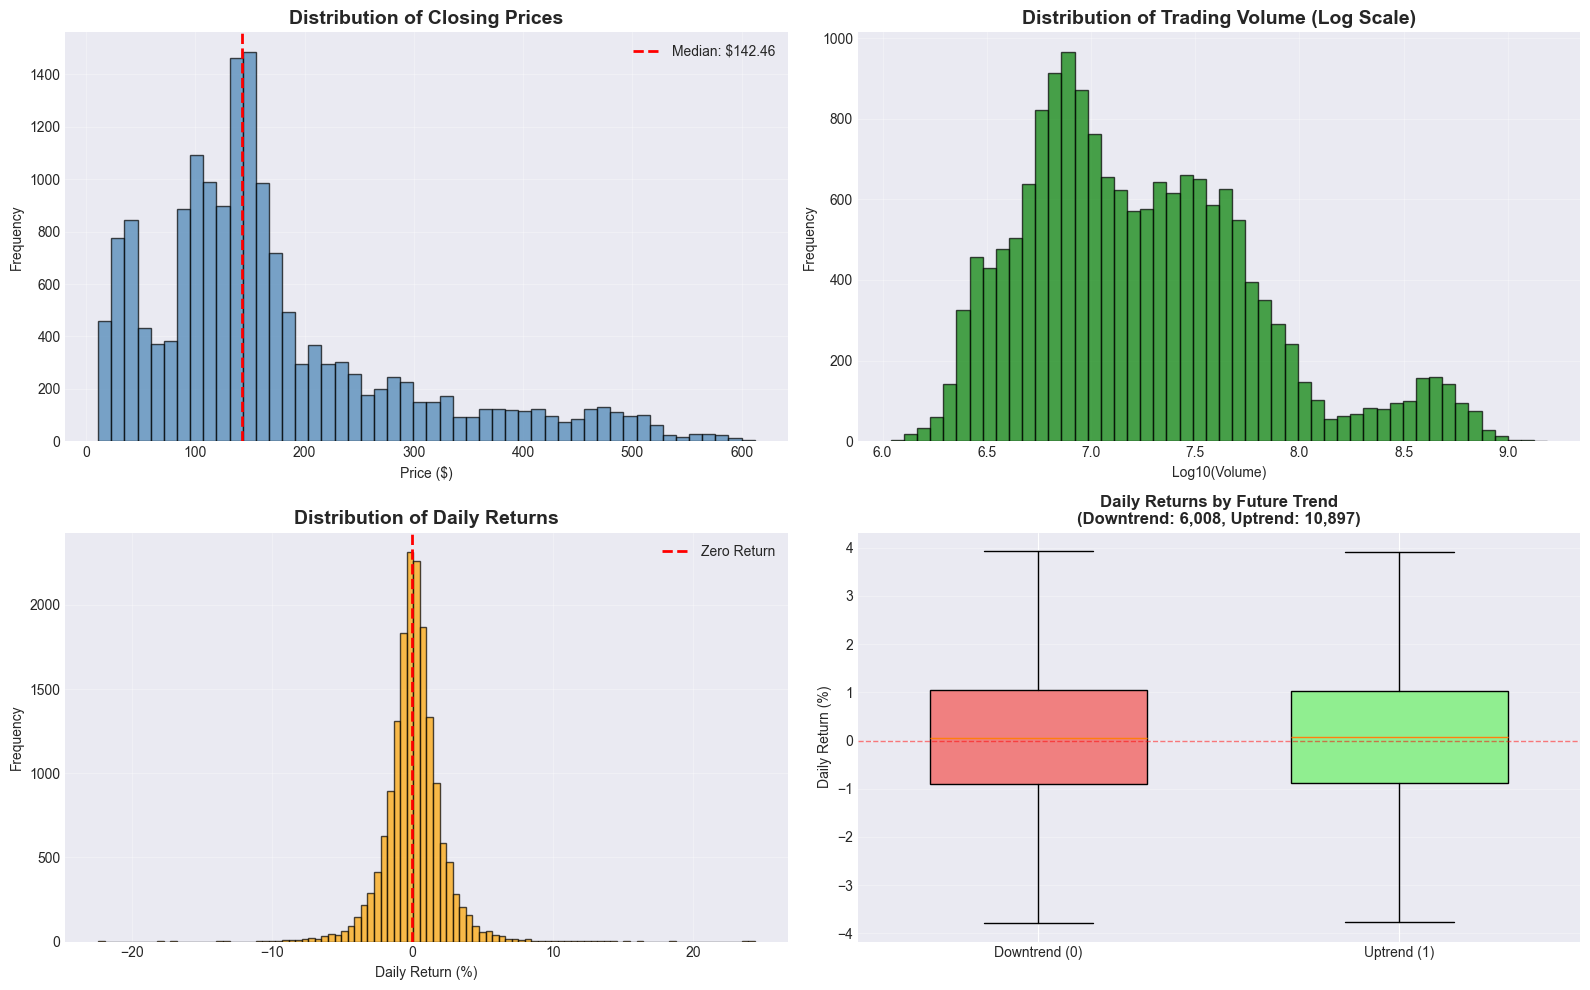


OVERALL VISUALIZATION 1 STATISTICS
Total data points: 16,920
Price range: $11.21 - $611.98
Daily returns mean: 0.0738%
Daily returns std: 2.0245%


In [8]:
# Visualization 1: Distribution of closing prices and daily returns
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Calculate daily returns if not already present
if 'Daily_Return' not in data.columns:
    data['Daily_Return'] = data.groupby('Symbol')['Close'].pct_change()

# 1. Closing price distribution
axes[0, 0].hist(data['Close'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].set_title('Distribution of Closing Prices', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Price ($)')
axes[0, 0].set_ylabel('Frequency')
median_price = data['Close'].median()
axes[0, 0].axvline(median_price, color='red', linestyle='--', linewidth=2, label=f"Median: ${median_price:.2f}")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Volume distribution (log scale)
volume_data = data['Volume'].dropna()
volume_data = volume_data[volume_data > 0]  # Remove zero volumes
axes[0, 1].hist(np.log10(volume_data), bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_title('Distribution of Trading Volume (Log Scale)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Log10(Volume)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# 3. Daily returns distribution
daily_returns = data['Daily_Return'].dropna() * 100
axes[1, 0].hist(daily_returns, bins=100, edgecolor='black', alpha=0.7, color='orange')
axes[1, 0].set_title('Distribution of Daily Returns', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Daily Return (%)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Return')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Box plot of daily returns by target class
print("\n" + "="*60)
print("VISUALIZATION 1 - SUBPLOT 4: Daily Returns by Future Trend")
print("="*60)

# Filter data with both Daily_Return and Target
data_with_returns = data.dropna(subset=['Daily_Return', 'Target']).copy()
print(f"Total samples with both Daily_Return and Target: {len(data_with_returns):,}")

# Check target distribution in filtered data
target_dist = data_with_returns['Target'].value_counts().sort_index()
print(f"\nTarget distribution in filtered data:")
for target_val, count in target_dist.items():
    label = "Uptrend" if target_val == 1.0 else "Downtrend"
    pct = count / len(data_with_returns) * 100
    print(f"  {label} ({int(target_val)}): {count:,} samples ({pct:.1f}%)")

# Separate data by target
downtrend_returns = data_with_returns[data_with_returns['Target'] == 0.0]['Daily_Return'] * 100
uptrend_returns = data_with_returns[data_with_returns['Target'] == 1.0]['Daily_Return'] * 100

print(f"\nDowntrend returns: {len(downtrend_returns):,} samples")
if len(downtrend_returns) > 0:
    print(f"  Mean: {downtrend_returns.mean():.4f}%, Std: {downtrend_returns.std():.4f}%")
    print(f"  Range: [{downtrend_returns.min():.2f}%, {downtrend_returns.max():.2f}%]")

print(f"\nUptrend returns: {len(uptrend_returns):,} samples")
if len(uptrend_returns) > 0:
    print(f"  Mean: {uptrend_returns.mean():.4f}%, Std: {uptrend_returns.std():.4f}%")
    print(f"  Range: [{uptrend_returns.min():.2f}%, {uptrend_returns.max():.2f}%]")

print("="*60 + "\n")

# Create boxplot based on available data
if len(downtrend_returns) > 0 and len(uptrend_returns) > 0:
    bp = axes[1, 1].boxplot([downtrend_returns, uptrend_returns],
                             labels=['Downtrend (0)', 'Uptrend (1)'],
                             patch_artist=True,
                             showfliers=False,  # Hide outliers for clarity
                             widths=0.6)
    
    # Color the boxes
    bp['boxes'][0].set_facecolor('lightcoral')
    bp['boxes'][1].set_facecolor('lightgreen')
    
    axes[1, 1].set_title(f'Daily Returns by Future Trend\n(Downtrend: {len(downtrend_returns):,}, Uptrend: {len(uptrend_returns):,})', 
                         fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Daily Return (%)')
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1)
    
elif len(downtrend_returns) > 0:
    bp = axes[1, 1].boxplot([downtrend_returns],
                             labels=['Downtrend (0)'],
                             patch_artist=True,
                             showfliers=False,
                             widths=0.6)
    bp['boxes'][0].set_facecolor('lightcoral')
    axes[1, 1].set_title(f'Daily Returns Distribution\n(Only Downtrend data: {len(downtrend_returns):,})', 
                         fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Daily Return (%)')
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
elif len(uptrend_returns) > 0:
    bp = axes[1, 1].boxplot([uptrend_returns],
                             labels=['Uptrend (1)'],
                             patch_artist=True,
                             showfliers=False,
                             widths=0.6)
    bp['boxes'][0].set_facecolor('lightgreen')
    axes[1, 1].set_title(f'Daily Returns Distribution\n(Only Uptrend data: {len(uptrend_returns):,})', 
                         fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Daily Return (%)')
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
else:
    axes[1, 1].text(0.5, 0.5, 'No target data available', 
                     ha='center', va='center', fontsize=14, color='red')
    axes[1, 1].set_title('Daily Returns by Future Trend', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("OVERALL VISUALIZATION 1 STATISTICS")
print("="*60)
print(f"Total data points: {len(data):,}")
print(f"Price range: ${data['Close'].min():.2f} - ${data['Close'].max():.2f}")
print(f"Daily returns mean: {data['Daily_Return'].mean()*100:.4f}%")
print(f"Daily returns std: {data['Daily_Return'].std()*100:.4f}%")
print("="*60)


### Visualization 2: Time Series Trends by Stock

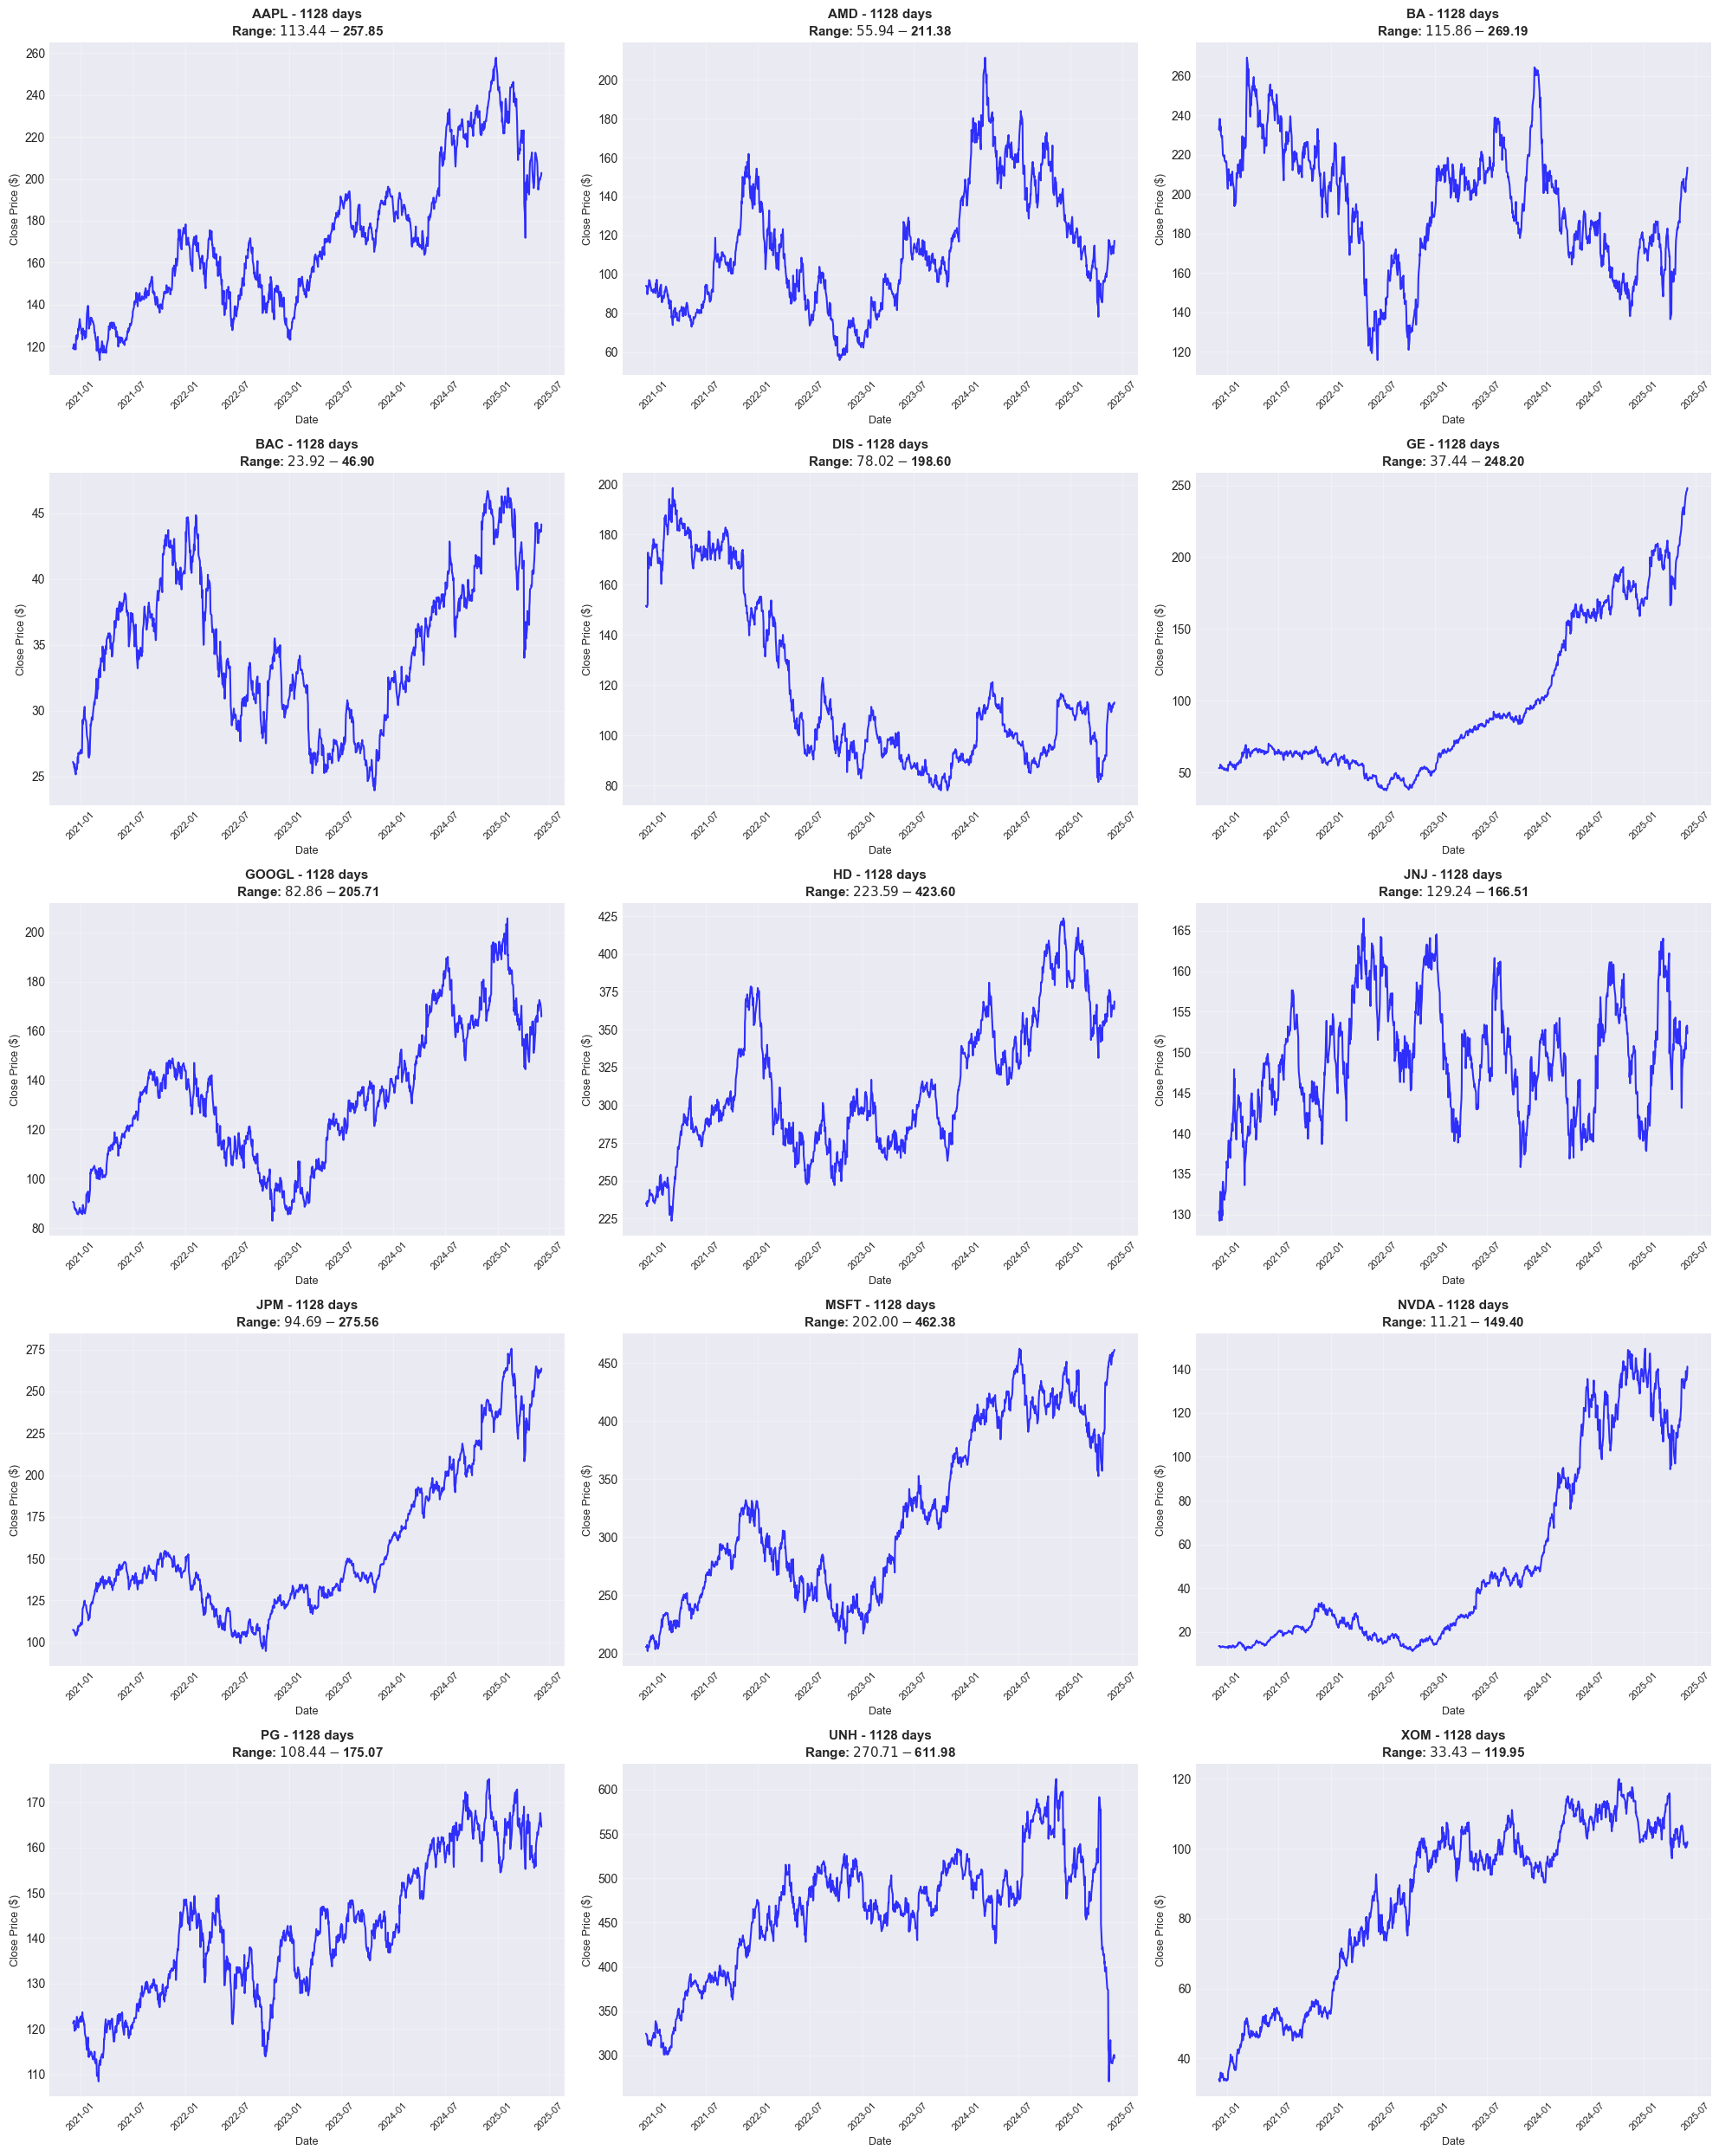


Visualization 2 complete - plotted 15 stocks


In [9]:
# Visualization 2: Stock price trends over time
# Ensure Date is datetime
if data['Date'].dtype != 'datetime64[ns]':
    data['Date'] = pd.to_datetime(data['Date'])

# Get list of stocks with data
stocks_to_plot = sorted(data['Symbol'].unique())
n_stocks = len(stocks_to_plot)

# Create subplot grid
n_cols = 3
n_rows = (n_stocks + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))

# Handle single row case
if n_stocks == 1:
    axes = np.array([axes])
elif n_rows == 1:
    axes = axes.reshape(1, -1)

# Flatten axes for easier indexing
axes_flat = axes.flatten()

for idx, symbol in enumerate(stocks_to_plot):
    # Get data for this symbol
    stock_data = data[data['Symbol'] == symbol].copy()
    stock_data = stock_data.sort_values('Date')
    
    # Filter out any invalid data
    stock_data = stock_data[stock_data['Close'].notna()]
    
    if len(stock_data) == 0:
        axes_flat[idx].text(0.5, 0.5, f'{symbol}\nNo Data', 
                            ha='center', va='center', fontsize=12)
        axes_flat[idx].set_title(f'{symbol} - No Data', fontsize=12, fontweight='bold')
        continue
    
    # Plot the data
    axes_flat[idx].plot(stock_data['Date'], stock_data['Close'], 
                        linewidth=1.5, color='blue', alpha=0.8)
    
    # Set title with stats
    price_min = stock_data['Close'].min()
    price_max = stock_data['Close'].max()
    n_days = len(stock_data)
    
    axes_flat[idx].set_title(
        f'{symbol} - {n_days} days\nRange: ${price_min:.2f} - ${price_max:.2f}', 
        fontsize=11, fontweight='bold'
    )
    
    axes_flat[idx].set_xlabel('Date', fontsize=9)
    axes_flat[idx].set_ylabel('Close Price ($)', fontsize=9)
    axes_flat[idx].grid(True, alpha=0.3)
    axes_flat[idx].tick_params(axis='x', rotation=45, labelsize=8)
    
# Hide empty subplots
for idx in range(n_stocks, len(axes_flat)):
    fig.delaxes(axes_flat[idx])

plt.tight_layout()
plt.show()

print(f"\nVisualization 2 complete - plotted {n_stocks} stocks")


### Visualization 3: Correlation Analysis

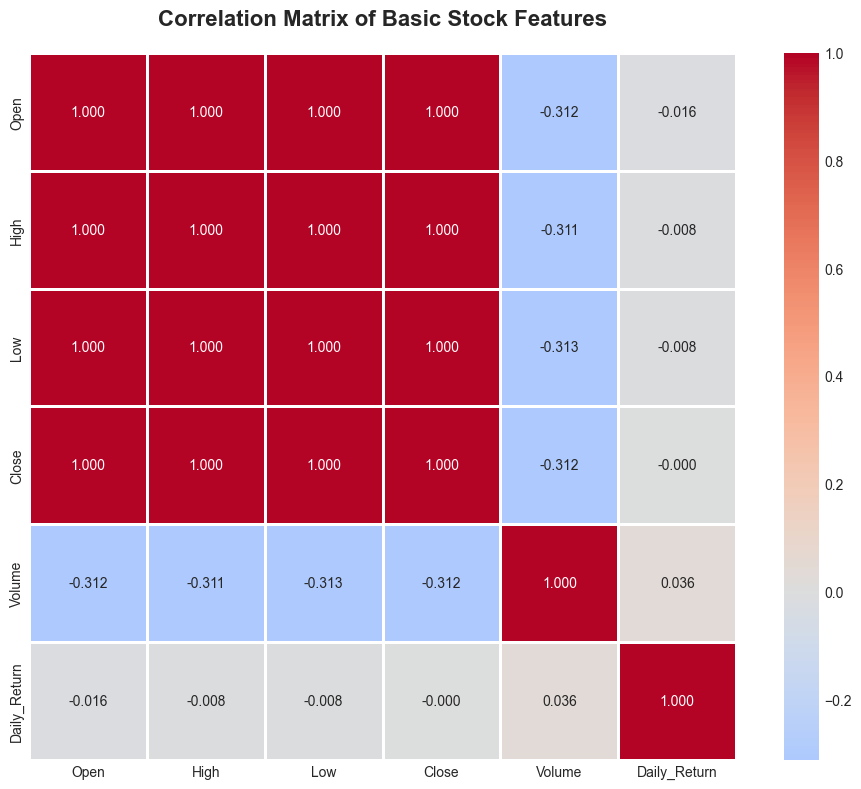

Key Correlations:
                  Open      High       Low     Close    Volume  Daily_Return
Open          1.000000  0.999861  0.999848  0.999698 -0.311671     -0.016045
High          0.999861  1.000000  0.999809  0.999857 -0.310611     -0.008415
Low           0.999848  0.999809  1.000000  0.999866 -0.313068     -0.007633
Close         0.999698  0.999857  0.999866  1.000000 -0.311800     -0.000299
Volume       -0.311671 -0.310611 -0.313068 -0.311800  1.000000      0.035830
Daily_Return -0.016045 -0.008415 -0.007633 -0.000299  0.035830      1.000000


In [10]:
# Visualization 3: Correlation heatmap of basic features
correlation_features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Daily_Return']
correlation_data = data[correlation_features].dropna()

plt.figure(figsize=(10, 8))
correlation_matrix = correlation_data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Correlation Matrix of Basic Stock Features', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("Key Correlations:")
print(correlation_matrix)

### Visualization 4: Class Balance and Target Distribution

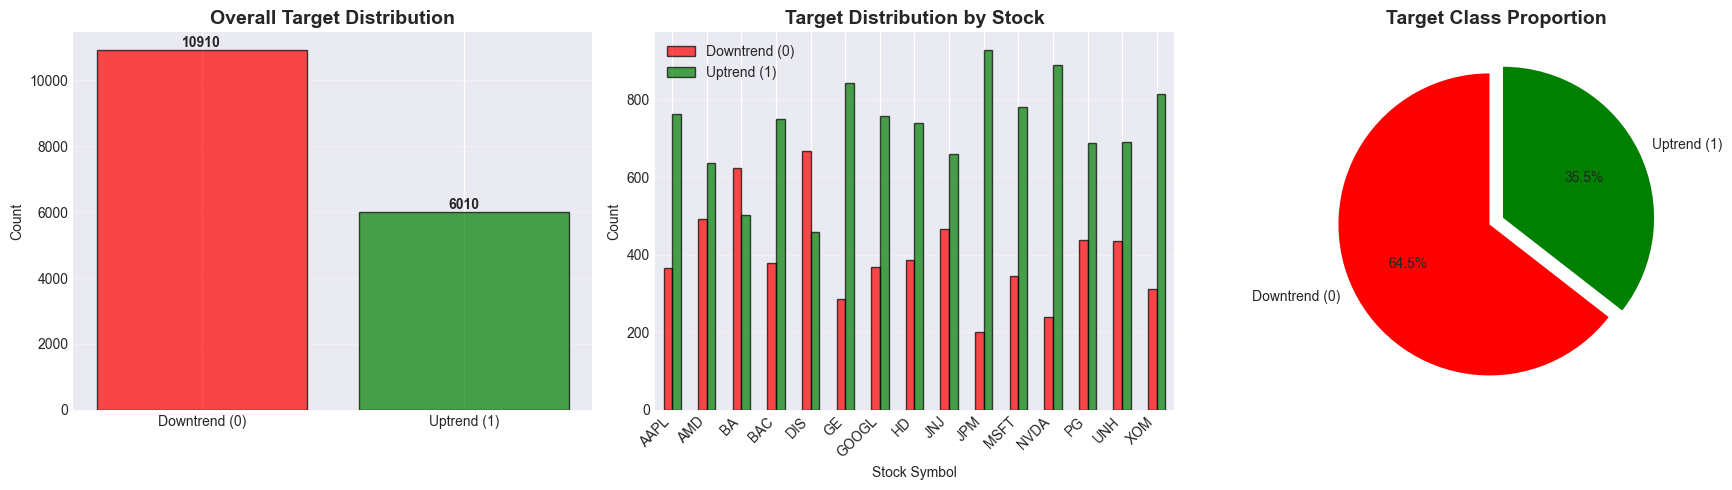


Class Balance Analysis:
Total samples with target: 16,920
Downtrend samples (0): 6,010 (35.5%)
Uptrend samples (1): 10,910 (64.5%)

Class imbalance ratio: 1.82:1


In [11]:
# Visualization 4: Target distribution analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Overall target distribution
target_counts = data['Target'].value_counts()
axes[0].bar(['Downtrend (0)', 'Uptrend (1)'], target_counts.values, 
            color=['red', 'green'], alpha=0.7, edgecolor='black')
axes[0].set_title('Overall Target Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(target_counts.values):
    axes[0].text(i, v + 100, str(v), ha='center', fontweight='bold')

# Target distribution by stock
stock_targets = data.groupby(['Symbol', 'Target']).size().unstack(fill_value=0)
stock_targets.plot(kind='bar', ax=axes[1], color=['red', 'green'], alpha=0.7, edgecolor='black')
axes[1].set_title('Target Distribution by Stock', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Stock Symbol')
axes[1].set_ylabel('Count')
axes[1].legend(['Downtrend (0)', 'Uptrend (1)'])
axes[1].grid(True, alpha=0.3, axis='y')
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')

# Pie chart
axes[2].pie(target_counts.values, labels=['Downtrend (0)', 'Uptrend (1)'], 
            autopct='%1.1f%%', colors=['red', 'green'], startangle=90,
            explode=(0.05, 0.05))
axes[2].set_title('Target Class Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Print class balance statistics
print("\nClass Balance Analysis:")
print(f"Total samples with target: {data['Target'].notna().sum():,}")
print(f"Downtrend samples (0): {target_counts.get(0, 0):,} ({target_counts.get(0, 0)/target_counts.sum()*100:.1f}%)")
print(f"Uptrend samples (1): {target_counts.get(1, 0):,} ({target_counts.get(1, 0)/target_counts.sum()*100:.1f}%)")
print(f"\nClass imbalance ratio: {max(target_counts.values)/min(target_counts.values):.2f}:1")

### Visualization 5: Outlier Detection with Volume and Price Range

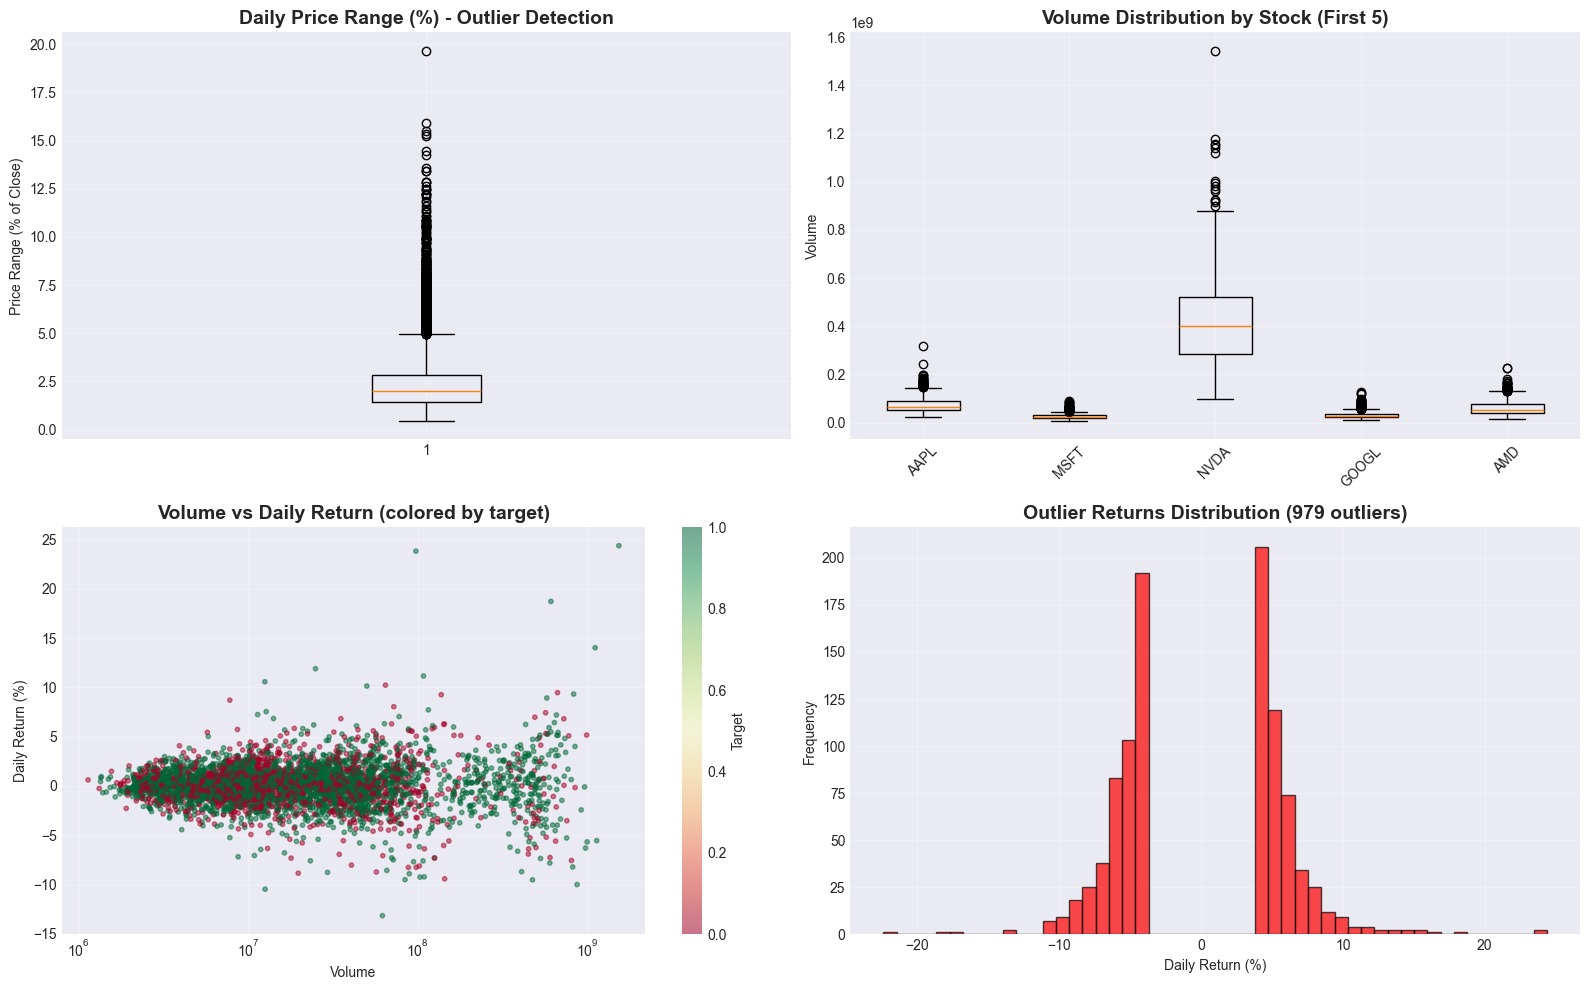


Outlier Statistics:
Total outlier returns: 979 (5.79%)
IQR bounds: [-3.78%, 3.93%]


In [12]:
# Visualization 5: Outlier analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Price range outliers
data['Price_Range'] = data['High'] - data['Low']
data['Price_Range_Pct'] = (data['Price_Range'] / data['Close']) * 100

axes[0, 0].boxplot(data['Price_Range_Pct'].dropna())
axes[0, 0].set_title('Daily Price Range (%) - Outlier Detection', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Price Range (% of Close)')
axes[0, 0].grid(True, alpha=0.3)

# 2. Volume outliers by stock
volume_by_stock = [data[data['Symbol'] == s]['Volume'].values for s in STOCK_SYMBOLS[:5]]  # First 5 for readability
axes[0, 1].boxplot(volume_by_stock, labels=STOCK_SYMBOLS[:5])
axes[0, 1].set_title('Volume Distribution by Stock (First 5)', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Volume')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# 3. Scatter plot: Volume vs Daily Return
sample_data = data.dropna(subset=['Volume', 'Daily_Return']).sample(n=min(5000, len(data)), random_state=42)
scatter = axes[1, 0].scatter(sample_data['Volume'], sample_data['Daily_Return'] * 100, 
                             c=sample_data['Target'], cmap='RdYlGn', alpha=0.5, s=10)
axes[1, 0].set_title('Volume vs Daily Return (colored by target)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Volume')
axes[1, 0].set_ylabel('Daily Return (%)')
axes[1, 0].set_xscale('log')
axes[1, 0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1, 0], label='Target')

# 4. Distribution of extreme returns
extreme_returns = data['Daily_Return'].dropna()
q1, q3 = extreme_returns.quantile([0.25, 0.75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = extreme_returns[(extreme_returns < lower_bound) | (extreme_returns > upper_bound)]
axes[1, 1].hist(outliers * 100, bins=50, edgecolor='black', alpha=0.7, color='red')
axes[1, 1].set_title(f'Outlier Returns Distribution ({len(outliers)} outliers)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Daily Return (%)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nOutlier Statistics:")
print(f"Total outlier returns: {len(outliers):,} ({len(outliers)/len(extreme_returns)*100:.2f}%)")
print(f"IQR bounds: [{lower_bound*100:.2f}%, {upper_bound*100:.2f}%]")

### Statistical Summary of Findings

Key insights from EDA:

In [13]:
# Statistical summary
print("=" * 80)
print("EXPLORATORY DATA ANALYSIS SUMMARY")
print("=" * 80)

print("\n1. DATA QUALITY:")
print(f"   - Total records: {len(data):,}")
print(f"   - Date range: {data['Date'].min()} to {data['Date'].max()}")
print(f"   - Missing target values: {data['Target'].isna().sum():,}")

print("\n2. PRICE CHARACTERISTICS:")
print(f"   - Mean closing price: ${data['Close'].mean():.2f}")
print(f"   - Price std deviation: ${data['Close'].std():.2f}")
print(f"   - Price range: ${data['Close'].min():.2f} - ${data['Close'].max():.2f}")

print("\n3. RETURNS ANALYSIS:")
daily_returns = data['Daily_Return'].dropna()
print(f"   - Mean daily return: {daily_returns.mean()*100:.4f}%")
print(f"   - Daily volatility (std): {daily_returns.std()*100:.4f}%")
print(f"   - Skewness: {daily_returns.skew():.4f}")
print(f"   - Kurtosis: {daily_returns.kurtosis():.4f}")

print("\n4. TARGET DISTRIBUTION:")
target_dist = data['Target'].value_counts(normalize=True)
print(f"   - Uptrend (1): {target_dist.get(1, 0)*100:.2f}%")
print(f"   - Downtrend (0): {target_dist.get(0, 0)*100:.2f}%")
print(f"   - Balance ratio: {max(data['Target'].value_counts())/min(data['Target'].value_counts()):.2f}:1")

print("\n5. VOLUME CHARACTERISTICS:")
print(f"   - Mean volume: {data['Volume'].mean():,.0f}")
print(f"   - Median volume: {data['Volume'].median():,.0f}")
print(f"   - Volume std: {data['Volume'].std():,.0f}")

print("\n" + "=" * 80)

EXPLORATORY DATA ANALYSIS SUMMARY

1. DATA QUALITY:
   - Total records: 16,920
   - Date range: 2020-12-04 00:00:00 to 2025-06-03 00:00:00
   - Missing target values: 0

2. PRICE CHARACTERISTICS:
   - Mean closing price: $169.32
   - Price std deviation: $117.36
   - Price range: $11.21 - $611.98

3. RETURNS ANALYSIS:
   - Mean daily return: 0.0738%
   - Daily volatility (std): 2.0245%
   - Skewness: 0.2071
   - Kurtosis: 8.7470

4. TARGET DISTRIBUTION:
   - Uptrend (1): 64.48%
   - Downtrend (0): 35.52%
   - Balance ratio: 1.82:1

5. VOLUME CHARACTERISTICS:
   - Mean volume: 49,493,948
   - Median volume: 14,084,800
   - Volume std: 111,716,814



## 4. Project Plan and Methodology

### ML Pipeline Overview
1. **Data Preparation**: Feature engineering, handling missing data, outlier treatment, encoding
2. **Feature Engineering**: Technical indicators (RSI, MACD, Bollinger Bands, Moving Averages, etc.)
3. **Data Splitting**: Train (70%), Validation (15%), Test (15%)
4. **Scaling**: RobustScaler for handling outliers
5. **Model Training**: 12 different models with appropriate configurations
6. **Evaluation**: Accuracy, Precision, Recall, F1, ROC-AUC
7. **Optimization**: Hyperparameter tuning for top performers

### Model Selection Justification
- **Linear Models** (Logistic, Polynomial): Baseline, interpretable
- **Tree-based** (DT, RF, Bagging, AdaBoost): Handle non-linearity, feature interactions
- **Distance-based** (KNN): Capture local patterns
- **Ensemble** (Stacking): Combine strengths of multiple models
- **SVM**: Effective in high-dimensional spaces
- **Neural Networks**: Learn complex patterns (varying depths)
- **RNN/LSTM**: Capture temporal dependencies in sequential data

### Evaluation Metrics
- **Accuracy**: Overall correctness
- **Precision**: Minimize false positive predictions
- **Recall**: Catch all actual uptrends
- **F1-Score**: Balance between precision and recall
- **ROC-AUC**: Model's ability to discriminate between classes

## 5. Data Preprocessing and Feature Engineering

In [14]:
# Feature engineering function
def engineer_features(df):
    """
    Create technical indicators and additional features.
    """
    df = df.copy()
    df = df.sort_values(['Symbol', 'Date'])
    
    # List to store processed dataframes
    processed_dfs = []
    
    for symbol in df['Symbol'].unique():
        symbol_df = df[df['Symbol'] == symbol].copy()
        
        # Price-based features
        symbol_df['Daily_Return'] = symbol_df['Close'].pct_change()
        symbol_df['Price_Range'] = symbol_df['High'] - symbol_df['Low']
        symbol_df['Price_Range_Pct'] = (symbol_df['Price_Range'] / symbol_df['Close']) * 100
        
        # Moving averages
        for window in [5, 10, 20, 50]:
            symbol_df[f'MA_{window}'] = symbol_df['Close'].rolling(window=window).mean()
            symbol_df[f'MA_{window}_Ratio'] = symbol_df['Close'] / symbol_df[f'MA_{window}']
        
        # Exponential moving averages
        for window in [12, 26]:
            symbol_df[f'EMA_{window}'] = symbol_df['Close'].ewm(span=window, adjust=False).mean()
        
        # Volatility
        for window in [5, 10, 20]:
            symbol_df[f'Volatility_{window}'] = symbol_df['Daily_Return'].rolling(window=window).std()
        
        # Volume features
        symbol_df['Volume_MA_20'] = symbol_df['Volume'].rolling(window=20).mean()
        symbol_df['Volume_Ratio'] = symbol_df['Volume'] / symbol_df['Volume_MA_20']
        symbol_df['Volume_Change'] = symbol_df['Volume'].pct_change()
        
        # Momentum indicators using pandas_ta
        symbol_df.ta.rsi(length=14, append=True)  # RSI
        symbol_df.ta.macd(append=True)  # MACD
        symbol_df.ta.bbands(length=20, append=True)  # Bollinger Bands
        symbol_df.ta.stoch(append=True)  # Stochastic Oscillator
        symbol_df.ta.adx(append=True)  # ADX
        symbol_df.ta.cci(append=True)  # CCI
        symbol_df.ta.willr(append=True)  # Williams %R
        
        # Lag features
        for lag in [1, 5, 10]:
            symbol_df[f'Return_Lag_{lag}'] = symbol_df['Daily_Return'].shift(lag)
            symbol_df[f'Close_Lag_{lag}'] = symbol_df['Close'].shift(lag)
        
        # Trend features
        symbol_df['Price_Trend_5'] = (symbol_df['Close'] - symbol_df['Close'].shift(5)) / symbol_df['Close'].shift(5)
        symbol_df['Price_Trend_10'] = (symbol_df['Close'] - symbol_df['Close'].shift(10)) / symbol_df['Close'].shift(10)
        
        processed_dfs.append(symbol_df)
    
    # Combine all processed data
    result_df = pd.concat(processed_dfs, ignore_index=True)
    
    return result_df

# Apply feature engineering
print("Applying feature engineering...")
data_features = engineer_features(data)
print(f"Features created. New shape: {data_features.shape}")
print(f"Total features: {len(data_features.columns)}")

Applying feature engineering...
Features created. New shape: (16920, 54)
Total features: 54


In [15]:
# Display new features
print("Engineered Features:")
print(data_features.columns.tolist())
print(f"\nSample of engineered features:")
data_features[['Symbol', 'Date', 'Close', 'MA_20', 'RSI_14', 'MACD_12_26_9', 'Volatility_20', 'Target']].head(30)

Engineered Features:
['Date', 'Symbol', 'Close', 'High', 'Low', 'Open', 'Volume', 'Future_Price', 'Target', 'Daily_Return', 'Price_Range', 'Price_Range_Pct', 'MA_5', 'MA_5_Ratio', 'MA_10', 'MA_10_Ratio', 'MA_20', 'MA_20_Ratio', 'MA_50', 'MA_50_Ratio', 'EMA_12', 'EMA_26', 'Volatility_5', 'Volatility_10', 'Volatility_20', 'Volume_MA_20', 'Volume_Ratio', 'Volume_Change', 'RSI_14', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'BBL_20_2.0_2.0', 'BBM_20_2.0_2.0', 'BBU_20_2.0_2.0', 'BBB_20_2.0_2.0', 'BBP_20_2.0_2.0', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'STOCHh_14_3_3', 'ADX_14', 'ADXR_14_2', 'DMP_14', 'DMN_14', 'CCI_14_0.015', 'WILLR_14', 'Return_Lag_1', 'Close_Lag_1', 'Return_Lag_5', 'Close_Lag_5', 'Return_Lag_10', 'Close_Lag_10', 'Price_Trend_5', 'Price_Trend_10']

Sample of engineered features:


,Symbol,Date,Close,MA_20,RSI_14,MACD_12_26_9,Volatility_20,Target
0,AAPL,2020-12-04,119.004532,NaN,NaN,NaN,NaN,1.0
1,AAPL,2020-12-07,120.464722,NaN,NaN,NaN,NaN,1.0
2,AAPL,2020-12-08,121.078003,NaN,NaN,NaN,NaN,1.0
3,AAPL,2020-12-09,118.547028,NaN,NaN,NaN,NaN,1.0
4,AAPL,2020-12-10,119.968262,NaN,NaN,NaN,NaN,1.0
5,AAPL,2020-12-11,119.160301,NaN,NaN,NaN,NaN,1.0
6,AAPL,2020-12-14,118.547028,NaN,NaN,NaN,NaN,1.0
7,AAPL,2020-12-15,124.485092,NaN,NaN,NaN,NaN,1.0
8,AAPL,2020-12-16,124.416954,NaN,NaN,NaN,NaN,1.0
9,AAPL,2020-12-17,125.283310,NaN,NaN,NaN,NaN,1.0


In [16]:
# Handle missing values
print("Missing values before imputation:")
print(data_features.isnull().sum().sort_values(ascending=False).head(20))

# Remove rows where target is missing (can't use for training)
data_clean = data_features.dropna(subset=['Target']).copy()
print(f"\nRows after removing missing targets: {len(data_clean):,}")

# Separate features and target
# Exclude non-feature columns
exclude_cols = ['Date', 'Symbol', 'Target', 'Future_Price']
feature_cols = [col for col in data_clean.columns if col not in exclude_cols]

X = data_clean[feature_cols]
y = data_clean['Target']

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nNumber of features: {len(feature_cols)}")

Missing values before imputation:
MA_50_Ratio       735
MA_50             735
MACD_12_26_9      495
MACDs_12_26_9     495
MACDh_12_26_9     495
ADXR_14_2         435
ADX_14            405
Volatility_20     300
BBU_20_2.0_2.0    285
BBM_20_2.0_2.0    285
BBL_20_2.0_2.0    285
BBB_20_2.0_2.0    285
BBP_20_2.0_2.0    285
Volume_Ratio      285
Volume_MA_20      285
MA_20             285
MA_20_Ratio       285
STOCHh_14_3_3     255
STOCHk_14_3_3     255
STOCHd_14_3_3     255
dtype: int64

Rows after removing missing targets: 16,920

Feature matrix shape: (16920, 50)
Target shape: (16920,)

Number of features: 50


In [17]:
# Outlier handling using quantile-based clipping
def handle_outliers(df, lower_quantile=0.01, upper_quantile=0.99):
    """
    Clip features to handle extreme outliers using quantile-based limits.
    This preserves feature variance unlike winsorization.
    """
    df_copy = df.copy()
    
    for col in df_copy.columns:
        if df_copy[col].dtype in ['float64', 'int64']:
            # Fill NaN with median first
            df_copy[col] = df_copy[col].fillna(df_copy[col].median())
            
            # Calculate quantile limits
            lower_limit = df_copy[col].quantile(lower_quantile)
            upper_limit = df_copy[col].quantile(upper_quantile)
            
            # Clip values to the limits
            df_copy[col] = df_copy[col].clip(lower=lower_limit, upper=upper_limit)
    
    return df_copy

print("Handling outliers...")
X_winsorized = handle_outliers(X)
print("Outliers handled using quantile-based clipping (1st and 99th percentiles)")

# Verify variance is preserved
print(f"\nVariance check after outlier handling:")
print(f"  Features with zero variance: {(X_winsorized.var() == 0).sum()}")
print(f"  Mean variance: {X_winsorized.var().mean():.6f}")
print(f"  Min variance: {X_winsorized.var().min():.6f}")

Handling outliers...
Outliers handled using quantile-based clipping (1st and 99th percentiles)

Variance check after outlier handling:
  Features with zero variance: 0
  Mean variance: 430408102567503.687500
  Min variance: 0.000075


In [18]:
# Impute remaining missing values
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(
    imputer.fit_transform(X_winsorized),
    columns=X_winsorized.columns,
    index=X_winsorized.index
)

print("Missing values after imputation:")
print(f"Total missing: {X_imputed.isnull().sum().sum()}")

# Check for infinite values
inf_count = np.isinf(X_imputed).sum().sum()
print(f"Infinite values: {inf_count}")

if inf_count > 0:
    X_imputed = X_imputed.replace([np.inf, -np.inf], np.nan)
    X_imputed = pd.DataFrame(
        imputer.fit_transform(X_imputed),
        columns=X_imputed.columns
    )
    print("Infinite values replaced and imputed")

Missing values after imputation:
Total missing: 0
Infinite values: 0


In [19]:
# Feature selection - remove low variance features
from sklearn.feature_selection import VarianceThreshold

print("Analyzing feature variances...")
print(f"Total features before selection: {len(feature_cols)}")
print(f"Data shape: {X_imputed.shape}\n")

# Check the variance distribution
feature_variances = X_imputed.var()
print(f"Variance statistics:")
print(f"  Min variance: {feature_variances.min():.6f}")
print(f"  Max variance: {feature_variances.max():.6f}")
print(f"  Mean variance: {feature_variances.mean():.6f}")
print(f"  Median variance: {feature_variances.median():.6f}\n")

# Determine appropriate threshold based on data
# Use a very low threshold since we're working with financial data that may have small variances
variance_threshold = max(0.0001, feature_variances.quantile(0.01))  # Use 1st percentile or 0.0001, whichever is larger

print(f"Using variance threshold: {variance_threshold:.6f}")

# Apply variance threshold
selector = VarianceThreshold(threshold=variance_threshold)
try:
    X_selected = selector.fit_transform(X_imputed)
    selected_features = X_imputed.columns[selector.get_support()].tolist()
    
    print(f"Features after variance threshold: {len(selected_features)}")
    print(f"Features removed: {len(feature_cols) - len(selected_features)}")
    
    # Show which features were removed if any
    removed_features = [f for f in feature_cols if f not in selected_features]
    if len(removed_features) > 0 and len(removed_features) <= 10:
        print(f"\nRemoved features: {removed_features}")
    elif len(removed_features) > 10:
        print(f"\nFirst 10 removed features: {removed_features[:10]}")
    
    X_final = pd.DataFrame(X_selected, columns=selected_features)
    
except ValueError as e:
    print(f"\nWARNING: Variance threshold too high - {e}")
    print("Skipping variance-based feature selection and keeping all features.")
    X_final = X_imputed.copy()
    selected_features = feature_cols

print(f"\nFinal feature count: {len(X_final.columns)}")
print(f"Final data shape: {X_final.shape}")


Analyzing feature variances...
Total features before selection: 50
Data shape: (16920, 50)

Variance statistics:
  Min variance: 0.000075
  Max variance: 10799034709157626.000000
  Mean variance: 430408102567503.687500
  Median variance: 88.203564

Using variance threshold: 0.000100
Features after variance threshold: 48
Features removed: 2

Removed features: ['Volatility_10', 'Volatility_20']

Final feature count: 48
Final data shape: (16920, 48)


In [20]:
# Train/Validation/Test split
# First split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X_final, y, test_size=0.30, random_state=42, stratify=y
)

# Second split: 50% of temp for validation, 50% for test (15% each of total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Data Split:")
print(f"Training set: {len(X_train):,} samples ({len(X_train)/len(X_final)*100:.1f}%)")
print(f"Validation set: {len(X_val):,} samples ({len(X_val)/len(X_final)*100:.1f}%)")
print(f"Test set: {len(X_test):,} samples ({len(X_test)/len(X_final)*100:.1f}%)")

print("\nClass distribution:")
print(f"Train - Uptrend: {y_train.sum()/len(y_train)*100:.1f}%, Downtrend: {(1-y_train.sum()/len(y_train))*100:.1f}%")
print(f"Val - Uptrend: {y_val.sum()/len(y_val)*100:.1f}%, Downtrend: {(1-y_val.sum()/len(y_val))*100:.1f}%")
print(f"Test - Uptrend: {y_test.sum()/len(y_test)*100:.1f}%, Downtrend: {(1-y_test.sum()/len(y_test))*100:.1f}%")

Data Split:
Training set: 11,844 samples (70.0%)
Validation set: 2,538 samples (15.0%)
Test set: 2,538 samples (15.0%)

Class distribution:
Train - Uptrend: 64.5%, Downtrend: 35.5%
Val - Uptrend: 64.5%, Downtrend: 35.5%
Test - Uptrend: 64.5%, Downtrend: 35.5%


In [21]:
# Feature scaling using RobustScaler (handles outliers better)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using RobustScaler")
print(f"Scaled training data shape: {X_train_scaled.shape}")

Features scaled using RobustScaler
Scaled training data shape: (11844, 48)


In [22]:
# OPTIONAL: Apply SMOTE to balance the training data
# NOTE: All models use class_weight='balanced', so SMOTE may not be necessary
# Uncomment the code below if you want to use SMOTE for oversampling
from imblearn.over_sampling import SMOTE

USE_SMOTE = False  # Set to True to enable SMOTE

if USE_SMOTE:
    print("\nBefore SMOTE:")
    print(f"Training set shape: {X_train_scaled.shape}")
    print(f"Class distribution: Uptrend (1): {y_train.sum()}, Downtrend (0): {len(y_train) - y_train.sum()}")
    
    # Apply conservative SMOTE - only partially balance
    smote = SMOTE(random_state=42, sampling_strategy=0.6, k_neighbors=3)
    X_train_scaled, y_train = smote.fit_resample(X_train_scaled, y_train)
    
    print("\nAfter SMOTE:")
    print(f"Training set shape: {X_train_scaled.shape}")
    print(f"Class distribution: Uptrend (1): {y_train.sum()}, Downtrend (0): {len(y_train) - y_train.sum()}")
else:
    print("\nSMOTE disabled - using class_weight='balanced' in models instead")
    print(f"Training set shape: {X_train_scaled.shape}")
    print(f"Class distribution: Uptrend (1): {int(y_train.sum())}, Downtrend (0): {int(len(y_train) - y_train.sum())}")


SMOTE disabled - using class_weight='balanced' in models instead
Training set shape: (11844, 48)
Class distribution: Uptrend (1): 7637, Downtrend (0): 4207


# Experiments

#### Experiment 5.1: Train/Test Split Strategy Comparison

Time series data requires careful splitting to prevent **temporal leakage** (using future data to predict past):
- **Random Stratified Split** (current): May leak future information into training
- **TimeSeriesSplit**: Respects temporal ordering, more realistic for production

We'll compare model stability across different folds using TimeSeriesSplit.


Running TimeSeriesSplit cross-validation...

TimeSeriesSplit Cross-Validation Results:
   Fold  Train_Size  Val_Size  Val_Accuracy    Val_F1
0     1        2820      2820      0.535816  0.666667
1     2        5640      2820      0.485461  0.560436
2     3        8460      2820      0.504965  0.622294
3     4       11280      2820      0.568440  0.665751
4     5       14100      2820      0.542908  0.599814

Mean Val Accuracy: 0.5275 (+/- 0.0326)
Mean Val F1: 0.6230 (+/- 0.0452)


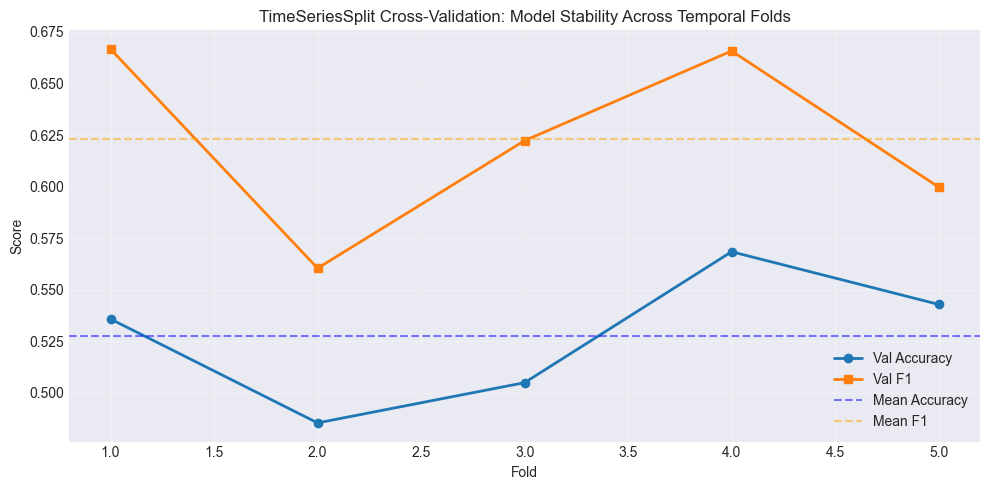


Insight: TimeSeriesSplit shows how model performance varies across different time periods.
Lower variance across folds indicates better generalization to new time periods.
Note: Random split may show higher performance but risks temporal leakage.


In [23]:
from sklearn.model_selection import TimeSeriesSplit

# TimeSeriesSplit (5 folds) - respects temporal ordering
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = []

print("Running TimeSeriesSplit cross-validation...")
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_final)):
    X_train_cv, X_val_cv = X_final.iloc[train_idx], X_final.iloc[val_idx]
    y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]
    
    # Scale
    scaler_cv = RobustScaler()
    X_train_scaled_cv = scaler_cv.fit_transform(X_train_cv)
    X_val_scaled_cv = scaler_cv.transform(X_val_cv)
    
    # Train
    model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
    model.fit(X_train_scaled_cv, y_train_cv)
    
    # Evaluate
    val_acc = model.score(X_val_scaled_cv, y_val_cv)
    val_f1 = f1_score(y_val_cv, model.predict(X_val_scaled_cv))
    
    cv_scores.append({
        'Fold': fold+1,
        'Train_Size': len(train_idx),
        'Val_Size': len(val_idx),
        'Val_Accuracy': val_acc,
        'Val_F1': val_f1
    })

cv_df = pd.DataFrame(cv_scores)
print("\nTimeSeriesSplit Cross-Validation Results:")
print(cv_df)
print(f"\nMean Val Accuracy: {cv_df['Val_Accuracy'].mean():.4f} (+/- {cv_df['Val_Accuracy'].std():.4f})")
print(f"Mean Val F1: {cv_df['Val_F1'].mean():.4f} (+/- {cv_df['Val_F1'].std():.4f})")

# Visualization
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(cv_df['Fold'], cv_df['Val_Accuracy'], marker='o', label='Val Accuracy', linewidth=2)
ax.plot(cv_df['Fold'], cv_df['Val_F1'], marker='s', label='Val F1', linewidth=2)
ax.axhline(y=cv_df['Val_Accuracy'].mean(), color='blue', linestyle='--', alpha=0.5, label='Mean Accuracy')
ax.axhline(y=cv_df['Val_F1'].mean(), color='orange', linestyle='--', alpha=0.5, label='Mean F1')

ax.set_xlabel('Fold')
ax.set_ylabel('Score')
ax.set_title('TimeSeriesSplit Cross-Validation: Model Stability Across Temporal Folds')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInsight: TimeSeriesSplit shows how model performance varies across different time periods.")
print("Lower variance across folds indicates better generalization to new time periods.")
print("Note: Random split may show higher performance but risks temporal leakage.")

#### Experiment 5.2: Random Forest Feature Importance

**Tree-based feature importance** (Gini importance) measures how much each feature contributes to reducing impurity across all trees.

Advantages:
- Captures feature interactions
- Non-linear relationships
- No assumptions about data distribution


Training Random Forest for feature importance...

Top 20 Most Important Features:
           feature  importance
19    Volume_MA_20    0.082762
14           MA_50    0.056122
17          EMA_26    0.047392
28  BBU_20_2.0_2.0    0.043327
27  BBM_20_2.0_2.0    0.037746
16          EMA_12    0.037507
2              Low    0.034234
26  BBL_20_2.0_2.0    0.033322
4           Volume    0.032058
8             MA_5    0.031211
0            Close    0.031012
10           MA_10    0.030829
1             High    0.030770
36          DMP_14    0.030185
25   MACDs_12_26_9    0.028737
12           MA_20    0.028186
37          DMN_14    0.027268
41     Close_Lag_1    0.025449
3             Open    0.025419
35       ADXR_14_2    0.025234

Performance with top 50 RF-selected features:
  Validation Accuracy: 0.5796
  Validation F1: 0.6411


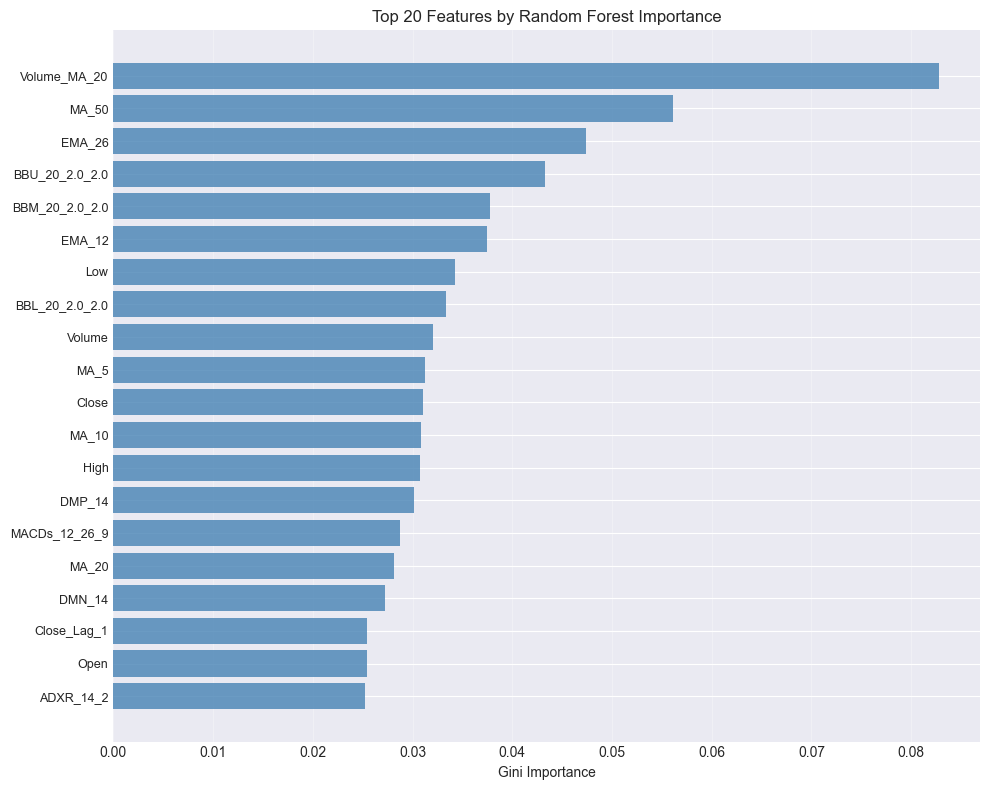


Insight: RF importance identifies features that contribute most to decision tree splits.
These features often capture complex interactions that linear models might miss.


In [27]:
# Train Random Forest for feature importance
print("Training Random Forest for feature importance...")
rf_selector = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10, 
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
# Scale data first
scaler_rf = RobustScaler()
X_train_scaled_rf = scaler_rf.fit_transform(X_train)
X_val_scaled_rf = scaler_rf.transform(X_val)
rf_selector.fit(X_train_scaled_rf, y_train)

# Extract feature importances
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_selector.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance.head(20))

# Select top 50 features (experiment only)
top_k = 50
top_features = feature_importance.head(top_k)['feature'].tolist()
X_train_rf_exp = X_train[top_features]
X_val_rf_exp = X_val[top_features]

# Evaluate with selected features (experiment)
scaler_rf_exp = RobustScaler()
X_train_scaled_rf_exp = scaler_rf_exp.fit_transform(X_train_rf_exp)
X_val_scaled_rf_exp = scaler_rf_exp.transform(X_val_rf_exp)

model_rf_exp = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
model_rf_exp.fit(X_train_scaled_rf_exp, y_train)
rf_val_acc = model_rf_exp.score(X_val_scaled_rf_exp, y_val)
rf_val_f1 = f1_score(y_val, model_rf_exp.predict(X_val_scaled_rf_exp))

print(f"\nPerformance with top {top_k} RF-selected features:")
print(f"  Validation Accuracy: {rf_val_acc:.4f}")
print(f"  Validation F1: {rf_val_f1:.4f}")

# Visualization: Top 20 features
fig, ax = plt.subplots(figsize=(10, 8))
top_20 = feature_importance.head(20)
ax.barh(range(len(top_20)), top_20['importance'], color='steelblue', alpha=0.8)
ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20['feature'], fontsize=9)
ax.set_xlabel('Gini Importance')
ax.set_title('Top 20 Features by Random Forest Importance')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nInsight: RF importance identifies features that contribute most to decision tree splits.")
print("These features often capture complex interactions that linear models might miss.")

## 6. Model Implementation and Training

We'll implement and evaluate 12 different models, tracking their performance on validation data.

In [28]:
# Initialize results storage
model_results = {}

def evaluate_model(name, model, X_train, y_train, X_val, y_val):
    """
    Train model and evaluate on validation set.
    """
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    
    # Get probabilities for ROC-AUC (if available)
    try:
        y_pred_proba_val = model.predict_proba(X_val)[:, 1]
        roc_auc = roc_auc_score(y_val, y_pred_proba_val)
    except:
        roc_auc = None
    
    # Calculate metrics
    results = {
        'model': model,
        'train_accuracy': accuracy_score(y_train, y_pred_train),
        'val_accuracy': accuracy_score(y_val, y_pred_val),
        'val_precision': precision_score(y_val, y_pred_val, zero_division=0),
        'val_recall': recall_score(y_val, y_pred_val, zero_division=0),
        'val_f1': f1_score(y_val, y_pred_val, zero_division=0),
        'val_roc_auc': roc_auc,
        'predictions_val': y_pred_val
    }
    
    # Check for overfitting
    overfit_gap = results['train_accuracy'] - results['val_accuracy']
    results['overfitting'] = overfit_gap > 0.1  # More than 10% gap
    results['overfit_gap'] = overfit_gap
    
    return results

def print_model_results(name, results):
    """
    Print formatted results for a model.
    """
    print(f"\n{'='*80}")
    print(f"{name}")
    print(f"{'='*80}")
    print(f"Training Accuracy:   {results['train_accuracy']:.4f}")
    print(f"Validation Accuracy: {results['val_accuracy']:.4f}")
    print(f"Precision:           {results['val_precision']:.4f}")
    print(f"Recall:              {results['val_recall']:.4f}")
    print(f"F1-Score:            {results['val_f1']:.4f}")
    if results['val_roc_auc']:
        print(f"ROC-AUC:             {results['val_roc_auc']:.4f}")
    print(f"\nOverfitting Gap:     {results['overfit_gap']:.4f}")
    if results['overfitting']:
        print("⚠️  WARNING: Possible overfitting detected (>10% gap)")
    print(f"{'='*80}")

### Model 1: Logistic Regression

In [29]:
# Logistic Regression
print("Training Logistic Regression...")
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced',
    C=1.0,  # Moderate regularization (was 0.1 - too strong, causing underfitting!)
    penalty='l2'
)
model_results['Logistic Regression'] = evaluate_model(
    'Logistic Regression', lr_model, X_train_scaled, y_train, X_val_scaled, y_val
)
print_model_results('Logistic Regression', model_results['Logistic Regression'])

Training Logistic Regression...

Logistic Regression
Training Accuracy:   0.5772
Validation Accuracy: 0.5800
Precision:           0.7135
Recall:              0.5828
F1-Score:            0.6416
ROC-AUC:             0.6073

Overfitting Gap:     -0.0028


### Model 2: Polynomial Logistic Regression

In [30]:
# Polynomial Logistic Regression
print("Training Polynomial Logistic Regression...")
poly_lr_model = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('lr', LogisticRegression(
        max_iter=1000,
        random_state=42,
        class_weight='balanced',
        C=0.1,  # Moderate regularization for polynomial features (was 0.01 - too strong!)
        penalty='l2'
    ))
])
model_results['Polynomial Logistic Regression'] = evaluate_model(
    'Polynomial Logistic Regression', poly_lr_model, X_train_scaled, y_train, X_val_scaled, y_val
)
print_model_results('Polynomial Logistic Regression', model_results['Polynomial Logistic Regression'])

Training Polynomial Logistic Regression...

Polynomial Logistic Regression
Training Accuracy:   0.6483
Validation Accuracy: 0.6170
Precision:           0.7540
Recall:              0.6029
F1-Score:            0.6701
ROC-AUC:             0.6800

Overfitting Gap:     0.0313


### Model 3: Decision Tree

In [31]:
# Decision Tree
print("Training Decision Tree...")
dt_model = DecisionTreeClassifier(
    max_depth=15,  # Increased from 7 to allow learning (was too restrictive!)
    min_samples_split=10,  # Reduced from 30 to allow more splits
    min_samples_leaf=5,  # Reduced from 15 to allow finer granularity
    random_state=42,
    class_weight='balanced'
)
model_results['Decision Tree'] = evaluate_model(
    'Decision Tree', dt_model, X_train_scaled, y_train, X_val_scaled, y_val
)
print_model_results('Decision Tree', model_results['Decision Tree'])

Training Decision Tree...

Decision Tree
Training Accuracy:   0.9372
Validation Accuracy: 0.8325
Precision:           0.9045
Recall:              0.8277
F1-Score:            0.8644
ROC-AUC:             0.8805

Overfitting Gap:     0.1046
⚠️  WARNING: Possible overfitting detected (>10% gap)


### Model 4: Random Forest

In [32]:
# Random Forest
print("Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,  # Increased from 10 to allow better learning
    min_samples_split=10,  # Reduced from 20 to allow more splits
    min_samples_leaf=4,  # Reduced from 10 to allow finer granularity
    max_features='sqrt',  # Keep feature sampling for generalization
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
model_results['Random Forest'] = evaluate_model(
    'Random Forest', rf_model, X_train_scaled, y_train, X_val_scaled, y_val
)
print_model_results('Random Forest', model_results['Random Forest'])

Training Random Forest...

Random Forest
Training Accuracy:   0.9879
Validation Accuracy: 0.8983
Precision:           0.9186
Recall:              0.9243
F1-Score:            0.9214
ROC-AUC:             0.9569

Overfitting Gap:     0.0896


### Model 5: K-Nearest Neighbors

In [33]:
# K-Nearest Neighbors
print("Training K-Nearest Neighbors...")
knn_model = KNeighborsClassifier(
    n_neighbors=15,  # Balanced setting (was 25 - too high, causing underfitting!)
    weights='distance',
    n_jobs=-1
)
model_results['K-Nearest Neighbors'] = evaluate_model(
    'K-Nearest Neighbors', knn_model, X_train_scaled, y_train, X_val_scaled, y_val
)
print_model_results('K-Nearest Neighbors', model_results['K-Nearest Neighbors'])

Training K-Nearest Neighbors...

K-Nearest Neighbors
Training Accuracy:   1.0000
Validation Accuracy: 0.7143
Precision:           0.7317
Recall:              0.8797
F1-Score:            0.7989
ROC-AUC:             0.7633

Overfitting Gap:     0.2857
⚠️  WARNING: Possible overfitting detected (>10% gap)


### Model 6: Bagging Classifier

In [34]:
# Bagging
print("Training Bagging Classifier...")
bagging_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(
        max_depth=15,  # Increased from 8 to allow learning
        min_samples_leaf=5  # Reduced from 10
    ),
    n_estimators=50,
    max_samples=0.8,  # Bagging fraction
    max_features=0.8,  # Feature sampling
    random_state=42,
    n_jobs=-1
)
model_results['Bagging'] = evaluate_model(
    'Bagging', bagging_model, X_train_scaled, y_train, X_val_scaled, y_val
)
print_model_results('Bagging', model_results['Bagging'])

Training Bagging Classifier...

Bagging
Training Accuracy:   0.9726
Validation Accuracy: 0.8964
Precision:           0.8962
Recall:              0.9493
F1-Score:            0.9220
ROC-AUC:             0.9549

Overfitting Gap:     0.0763


### Model 7: Stacking Classifier

In [35]:
# Stacking Classifier
print("Training Stacking Classifier...")

# Use balanced base estimators with moderate regularization
base_estimators = [
    ('lr', LogisticRegression(max_iter=1000, C=1.0, class_weight='balanced', random_state=42)),
    ('dt', DecisionTreeClassifier(max_depth=15, min_samples_split=10, min_samples_leaf=5, class_weight='balanced', random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=50, max_depth=20, min_samples_split=10, max_features='sqrt', class_weight='balanced', random_state=42, n_jobs=-1))
]

stacking_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(max_iter=1000, C=1.0, class_weight='balanced'),
    cv=5,  # Cross-validation to prevent overfitting
    n_jobs=-1
)
model_results['Stacking'] = evaluate_model(
    'Stacking', stacking_model, X_train_scaled, y_train, X_val_scaled, y_val
)
print_model_results('Stacking', model_results['Stacking'])

Training Stacking Classifier...

Stacking
Training Accuracy:   0.9895
Validation Accuracy: 0.9054
Precision:           0.9452
Recall:              0.9059
F1-Score:            0.9251
ROC-AUC:             0.9602

Overfitting Gap:     0.0841


### Model 8: Support Vector Machine

In [36]:
# SVM
print("Training Support Vector Machine...")
svm_model = SVC(
    kernel='rbf',
    C=1.0,  # Moderate regularization (was 0.5 - too strong!)
    gamma='scale',  # Use scale instead of auto
    random_state=42,
    class_weight='balanced',
    probability=True,
    max_iter=1000
)
model_results['SVM'] = evaluate_model(
    'SVM', svm_model, X_train_scaled, y_train, X_val_scaled, y_val
)
print_model_results('SVM', model_results['SVM'])

Training Support Vector Machine...

SVM
Training Accuracy:   0.3767
Validation Accuracy: 0.3759
Precision:           0.8841
Recall:              0.0373
F1-Score:            0.0715
ROC-AUC:             0.5187

Overfitting Gap:     0.0008


### Model 9: AdaBoost

In [37]:
# AdaBoost
print("Training AdaBoost...")
ada_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(
        max_depth=10,  # Increased to allow better base learners
        min_samples_split=10,  # Reduced to allow more flexibility
        min_samples_leaf=4  # Reasonable constraint
    ),
    n_estimators=50,
    learning_rate=1.0,  # Standard learning rate
    random_state=42,
    algorithm='SAMME'  # Use SAMME (more stable than SAMME.R for weak learners)
)
model_results['AdaBoost'] = evaluate_model(
    'AdaBoost', ada_model, X_train_scaled, y_train, X_val_scaled, y_val
)
print_model_results('AdaBoost', model_results['AdaBoost'])

Training AdaBoost...

AdaBoost
Training Accuracy:   1.0000
Validation Accuracy: 0.9086
Precision:           0.9101
Recall:              0.9524
F1-Score:            0.9307
ROC-AUC:             0.9578

Overfitting Gap:     0.0914


### Model 10: Neural Networks (3 Architectures)

We'll implement three different neural network architectures:
1. Simple: 2 hidden layers
2. Moderate: 4 hidden layers
3. Complex: 6 hidden layers

In [38]:
# Helper function for neural network evaluation
def evaluate_nn_model(name, model, X_train, y_train, X_val, y_val, epochs=50, batch_size=32):
    """
    Train and evaluate neural network model.
    """
    # Calculate class weights
    class_weight = {0: len(y_train) / (2 * (y_train == 0).sum()),
                   1: len(y_train) / (2 * (y_train == 1).sum())}
    
    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=0)
    
    # Train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        class_weight=class_weight,
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )
    
    # Predict
    y_pred_train = (model.predict(X_train, verbose=0) > 0.5).astype(int).flatten()
    y_pred_val = (model.predict(X_val, verbose=0) > 0.5).astype(int).flatten()
    y_pred_proba_val = model.predict(X_val, verbose=0).flatten()
    
    # Calculate metrics
    results = {
        'model': model,
        'history': history,
        'train_accuracy': accuracy_score(y_train, y_pred_train),
        'val_accuracy': accuracy_score(y_val, y_pred_val),
        'val_precision': precision_score(y_val, y_pred_val, zero_division=0),
        'val_recall': recall_score(y_val, y_pred_val, zero_division=0),
        'val_f1': f1_score(y_val, y_pred_val, zero_division=0),
        'val_roc_auc': roc_auc_score(y_val, y_pred_proba_val),
        'predictions_val': y_pred_val
    }
    
    # Check for overfitting
    overfit_gap = results['train_accuracy'] - results['val_accuracy']
    results['overfitting'] = overfit_gap > 0.1
    results['overfit_gap'] = overfit_gap
    
    return results

In [39]:
# Neural Network - Simple Architecture
print("Training Simple Neural Network...")
nn_simple = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
nn_simple.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model_results['NN - Simple'] = evaluate_nn_model(
    'NN - Simple', nn_simple, X_train_scaled, y_train, X_val_scaled, y_val
)
print_model_results('Neural Network - Simple', model_results['NN - Simple'])

Training Simple Neural Network...


2025-12-02 23:58:48.111255: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-12-02 23:58:48.111582: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-12-02 23:58:48.111939: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-12-02 23:58:48.112001: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-02 23:58:48.112725: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-12-02 23:58:48.844806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.



Neural Network - Simple
Training Accuracy:   0.5882
Validation Accuracy: 0.5879
Precision:           0.7045
Recall:              0.6219
F1-Score:            0.6606
ROC-AUC:             0.6012

Overfitting Gap:     0.0004


In [40]:
# Neural Network - Moderate Architecture
print("Training Moderate Neural Network...")
nn_moderate = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])
nn_moderate.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model_results['NN - Moderate'] = evaluate_nn_model(
    'NN - Moderate', nn_moderate, X_train_scaled, y_train, X_val_scaled, y_val
)
print_model_results('Neural Network - Moderate', model_results['NN - Moderate'])

Training Moderate Neural Network...

Neural Network - Moderate
Training Accuracy:   0.5843
Validation Accuracy: 0.5902
Precision:           0.6874
Recall:              0.6689
F1-Score:            0.6780
ROC-AUC:             0.6025

Overfitting Gap:     -0.0059


In [41]:
# Neural Network - Complex Architecture
print("Training Complex Neural Network...")
nn_complex = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])
nn_complex.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model_results['NN - Complex'] = evaluate_nn_model(
    'NN - Complex', nn_complex, X_train_scaled, y_train, X_val_scaled, y_val, epochs=100
)
print_model_results('Neural Network - Complex', model_results['NN - Complex'])

Training Complex Neural Network...

Neural Network - Complex
Training Accuracy:   0.5882
Validation Accuracy: 0.6048
Precision:           0.6898
Recall:              0.7037
F1-Score:            0.6967
ROC-AUC:             0.6139

Overfitting Gap:     -0.0166


### Model 11: Recurrent Neural Network (RNN)

In [42]:
# Prepare data for RNN (reshape to 3D: samples, timesteps, features)
# We'll use a simple approach with timesteps=1 for this architecture
X_train_rnn = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_rnn = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))

print("Training Recurrent Neural Network...")
rnn_model = Sequential([
    SimpleRNN(64, activation='tanh', return_sequences=True, input_shape=(1, X_train_scaled.shape[1])),
    Dropout(0.3),
    SimpleRNN(32, activation='tanh'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])
rnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model_results['RNN'] = evaluate_nn_model(
    'RNN', rnn_model, X_train_rnn, y_train, X_val_rnn, y_val
)
print_model_results('Recurrent Neural Network', model_results['RNN'])

Training Recurrent Neural Network...

Recurrent Neural Network
Training Accuracy:   0.5908
Validation Accuracy: 0.6072
Precision:           0.7432
Recall:              0.5974
F1-Score:            0.6624
ROC-AUC:             0.6241

Overfitting Gap:     -0.0164


### Model 12: Long Short-Term Memory (LSTM)

In [43]:
# LSTM Model
print("Training LSTM...")
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(1, X_train_scaled.shape[1])),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model_results['LSTM'] = evaluate_nn_model(
    'LSTM', lstm_model, X_train_rnn, y_train, X_val_rnn, y_val
)
print_model_results('LSTM', model_results['LSTM'])

Training LSTM...

LSTM
Training Accuracy:   0.7624
Validation Accuracy: 0.7151
Precision:           0.8426
Recall:              0.6866
F1-Score:            0.7566
ROC-AUC:             0.7956

Overfitting Gap:     0.0473


## 7. Model Evaluation and Comparison

In [44]:
# Create comprehensive comparison table
comparison_data = []
for name, results in model_results.items():
    comparison_data.append({
        'Model': name,
        'Train Acc': results['train_accuracy'],
        'Val Acc': results['val_accuracy'],
        'Precision': results['val_precision'],
        'Recall': results['val_recall'],
        'F1-Score': results['val_f1'],
        'ROC-AUC': results['val_roc_auc'] if results['val_roc_auc'] else 0,
        'Overfit Gap': results['overfit_gap']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Val Acc', ascending=False)

print("\n" + "="*100)
print("MODEL PERFORMANCE COMPARISON")
print("="*100)
print(comparison_df.to_string(index=False))
print("="*100)


MODEL PERFORMANCE COMPARISON
                         Model  Train Acc  Val Acc  Precision   Recall  F1-Score  ROC-AUC  Overfit Gap
                      AdaBoost   1.000000 0.908589   0.910099 0.952352  0.930746 0.957846     0.091411
                      Stacking   0.989531 0.905437   0.945188 0.905925  0.925140 0.960192     0.084093
                 Random Forest   0.987926 0.898345   0.918640 0.924252  0.921437 0.956899     0.089581
                       Bagging   0.972644 0.896375   0.896194 0.949297  0.921982 0.954925     0.076269
                 Decision Tree   0.937183 0.832545   0.904539 0.827734  0.864434 0.880486     0.104638
                          LSTM   0.762411 0.715130   0.842579 0.686622  0.756648 0.795598     0.047281
           K-Nearest Neighbors   1.000000 0.714342   0.731707 0.879658  0.798890 0.763320     0.285658
Polynomial Logistic Regression   0.648345 0.617021   0.754011 0.602932  0.670061 0.679997     0.031324
                           RNN   0.590763 0

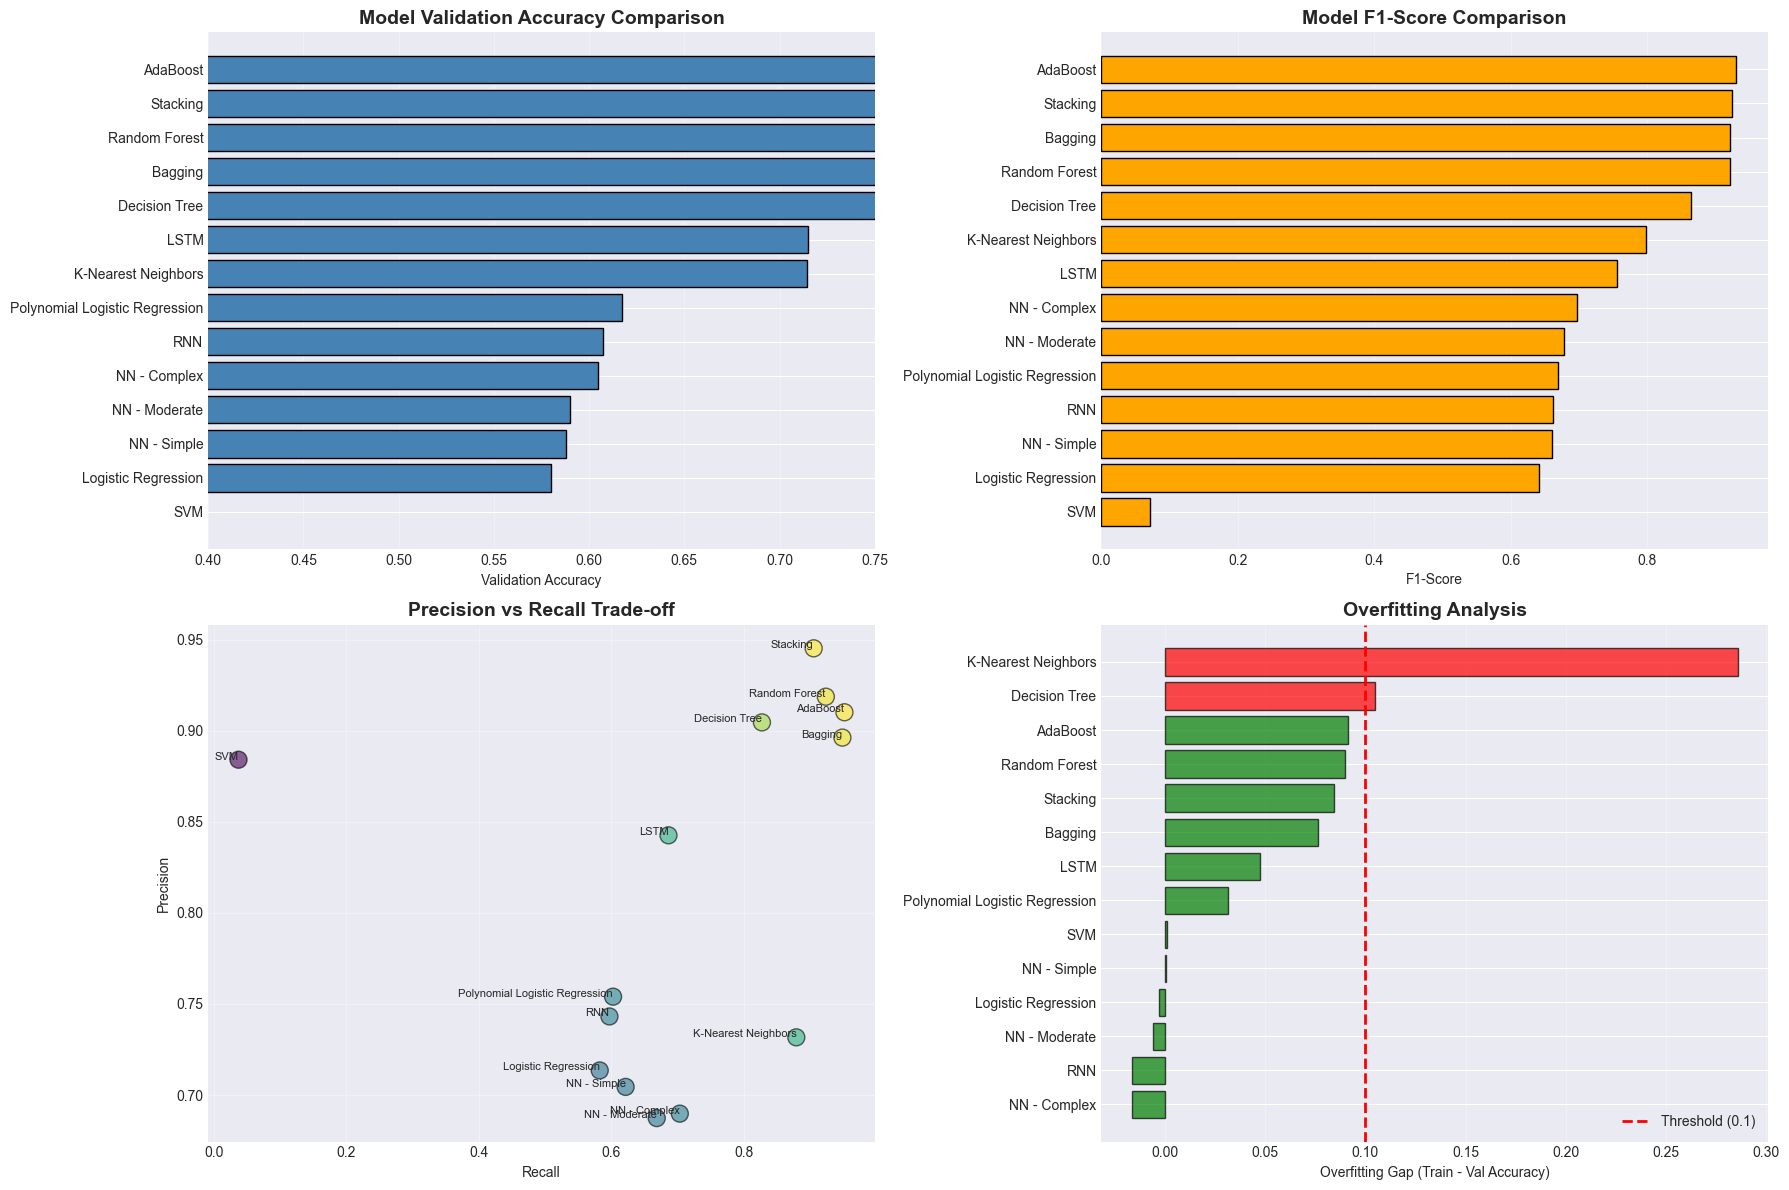

In [45]:
# Visualization: Model comparison
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Validation Accuracy comparison
comparison_df_sorted = comparison_df.sort_values('Val Acc')
axes[0, 0].barh(comparison_df_sorted['Model'], comparison_df_sorted['Val Acc'], color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('Validation Accuracy')
axes[0, 0].set_title('Model Validation Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='x')
axes[0, 0].set_xlim([0.4, 0.75])

# 2. F1-Score comparison
comparison_df_sorted_f1 = comparison_df.sort_values('F1-Score')
axes[0, 1].barh(comparison_df_sorted_f1['Model'], comparison_df_sorted_f1['F1-Score'], color='orange', edgecolor='black')
axes[0, 1].set_xlabel('F1-Score')
axes[0, 1].set_title('Model F1-Score Comparison', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='x')

# 3. Precision vs Recall
axes[1, 0].scatter(comparison_df['Recall'], comparison_df['Precision'], s=150, alpha=0.6, c=comparison_df['Val Acc'], cmap='viridis', edgecolor='black')
for idx, row in comparison_df.iterrows():
    axes[1, 0].annotate(row['Model'], (row['Recall'], row['Precision']), fontsize=8, ha='right')
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Precision vs Recall Trade-off', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Overfitting analysis
comparison_df_sorted_over = comparison_df.sort_values('Overfit Gap')
colors = ['red' if x > 0.1 else 'green' for x in comparison_df_sorted_over['Overfit Gap']]
axes[1, 1].barh(comparison_df_sorted_over['Model'], comparison_df_sorted_over['Overfit Gap'], color=colors, edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Overfitting Gap (Train - Val Accuracy)')
axes[1, 1].set_title('Overfitting Analysis', fontsize=14, fontweight='bold')
axes[1, 1].axvline(x=0.1, color='red', linestyle='--', linewidth=2, label='Threshold (0.1)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

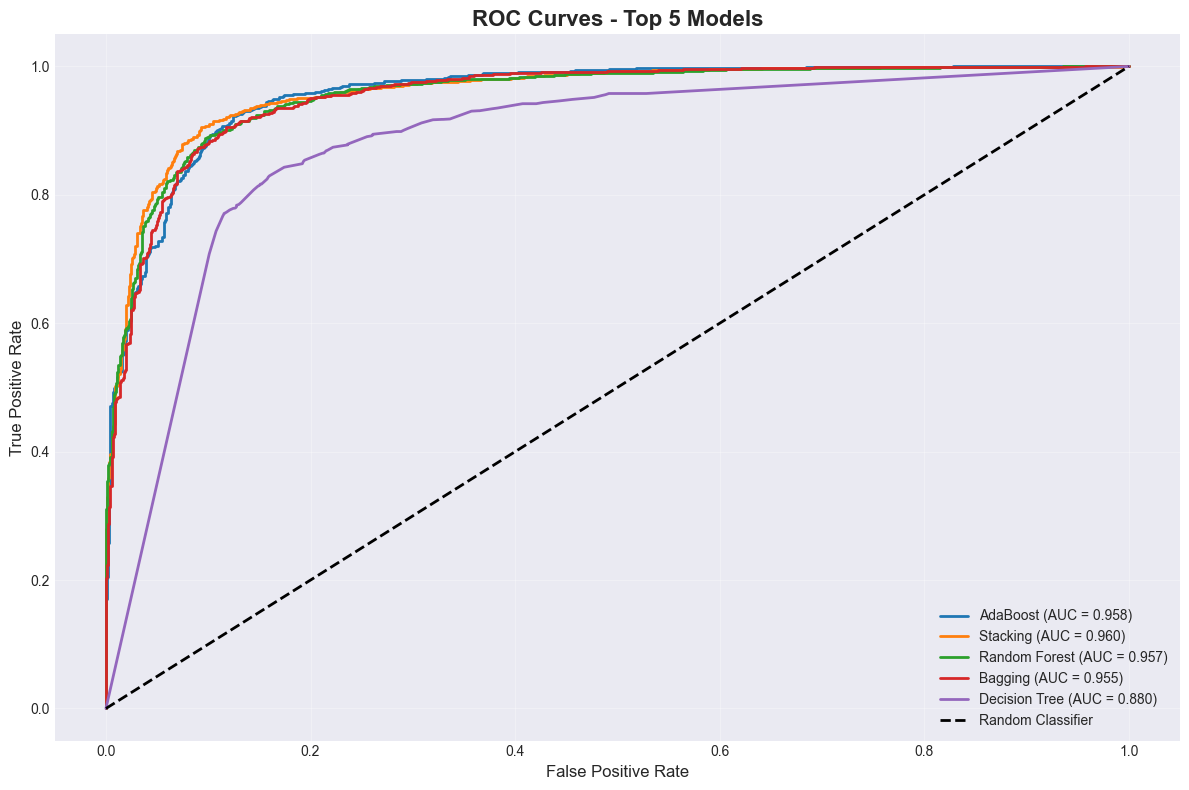

In [46]:
# ROC Curves for top 5 models
top_5_models = comparison_df.nlargest(5, 'Val Acc')['Model'].tolist()

plt.figure(figsize=(12, 8))
for model_name in top_5_models:
    results = model_results[model_name]
    if results['val_roc_auc']:
        # Get predictions
        model = results['model']
        if 'NN' in model_name or 'RNN' in model_name or 'LSTM' in model_name:
            if 'RNN' in model_name or 'LSTM' in model_name:
                y_pred_proba = model.predict(X_val_rnn, verbose=0).flatten()
            else:
                y_pred_proba = model.predict(X_val_scaled, verbose=0).flatten()
        else:
            y_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
        
        fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
        plt.plot(fpr, tpr, linewidth=2, label=f"{model_name} (AUC = {results['val_roc_auc']:.3f})")

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Top 5 Models', fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

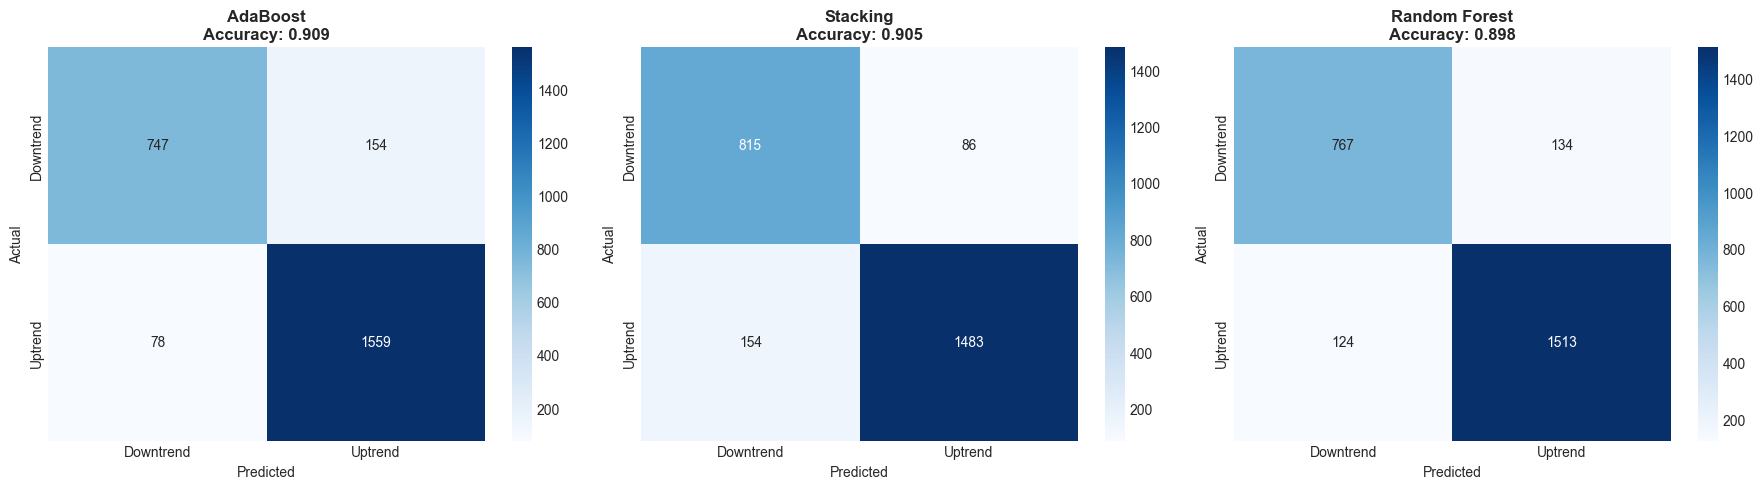

In [47]:
# Confusion matrices for top 3 models
top_3_models = comparison_df.nlargest(3, 'Val Acc')['Model'].tolist()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, model_name in enumerate(top_3_models):
    results = model_results[model_name]
    cm = confusion_matrix(y_val, results['predictions_val'])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], 
                xticklabels=['Downtrend', 'Uptrend'],
                yticklabels=['Downtrend', 'Uptrend'])
    axes[idx].set_title(f'{model_name}\nAccuracy: {results["val_accuracy"]:.3f}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

## 8. Hyperparameter Tuning

We'll tune the top 3 performing models using GridSearchCV.

In [48]:
# Get top 3 traditional ML models (exclude neural networks for grid search)
traditional_models = {k: v for k, v in model_results.items() 
                     if 'NN' not in k and 'RNN' not in k and 'LSTM' not in k}
top_3_traditional = sorted(traditional_models.items(), 
                          key=lambda x: x[1]['val_accuracy'], 
                          reverse=True)[:3]

print("Top 3 traditional models for hyperparameter tuning:")
for name, results in top_3_traditional:
    print(f"  {name}: {results['val_accuracy']:.4f}")

Top 3 traditional models for hyperparameter tuning:
  AdaBoost: 0.9086
  Stacking: 0.9054
  Random Forest: 0.8983


In [49]:
# Hyperparameter tuning for Random Forest (if in top 3)
tuned_results = {}

if any('Random Forest' in name for name, _ in top_3_traditional):
    print("\nTuning Random Forest...")
    rf_params = {
        'n_estimators': [100, 200],
        'max_depth': [10, 15, 20],
        'min_samples_split': [5, 10],
        'min_samples_leaf': [2, 4]
    }
    
    rf_grid = GridSearchCV(
        RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1),
        rf_params, cv=3, scoring='f1', n_jobs=-1, verbose=1
    )
    rf_grid.fit(X_train_scaled, y_train)
    
    print(f"Best parameters: {rf_grid.best_params_}")
    print(f"Best CV F1-score: {rf_grid.best_score_:.4f}")
    
    tuned_results['Random Forest (Tuned)'] = evaluate_model(
        'Random Forest (Tuned)', rf_grid.best_estimator_, 
        X_train_scaled, y_train, X_val_scaled, y_val
    )
    print_model_results('Random Forest (Tuned)', tuned_results['Random Forest (Tuned)'])


Tuning Random Forest...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best CV F1-score: 0.9138

Random Forest (Tuned)
Training Accuracy:   0.9974
Validation Accuracy: 0.9074
Precision:           0.9198
Recall:              0.9383
F1-Score:            0.9289
ROC-AUC:             0.9627

Overfitting Gap:     0.0900


In [50]:
# Hyperparameter tuning for AdaBoost (if in top 3)
if any('AdaBoost' in name for name, _ in top_3_traditional):
    print("\nTuning AdaBoost...")
    ada_params = {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 0.5],
        'estimator__max_depth': [2, 3, 4]
    }
    
    ada_grid = GridSearchCV(
        AdaBoostClassifier(estimator=DecisionTreeClassifier(), random_state=42),
        ada_params, cv=3, scoring='f1', n_jobs=-1, verbose=1
    )
    ada_grid.fit(X_train_scaled, y_train)
    
    print(f"Best parameters: {ada_grid.best_params_}")
    print(f"Best CV F1-score: {ada_grid.best_score_:.4f}")
    
    tuned_results['AdaBoost (Tuned)'] = evaluate_model(
        'AdaBoost (Tuned)', ada_grid.best_estimator_, 
        X_train_scaled, y_train, X_val_scaled, y_val
    )
    print_model_results('AdaBoost (Tuned)', tuned_results['AdaBoost (Tuned)'])


Tuning AdaBoost...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters: {'estimator__max_depth': 4, 'learning_rate': 0.5, 'n_estimators': 150}
Best CV F1-score: 0.8279

AdaBoost (Tuned)
Training Accuracy:   0.7622
Validation Accuracy: 0.7376
Precision:           0.7538
Recall:              0.8809
F1-Score:            0.8124
ROC-AUC:             0.8036

Overfitting Gap:     0.0246


In [51]:
# Hyperparameter tuning for SVM (if in top 3)
if any('SVM' in name for name, _ in top_3_traditional):
    print("\nTuning SVM...")
    svm_params = {
        'C': [0.1, 1.0, 10.0],
        'gamma': ['scale', 'auto'],
        'kernel': ['rbf', 'poly']
    }
    
    svm_grid = GridSearchCV(
        SVC(probability=True, random_state=42, class_weight='balanced'),
        svm_params, cv=3, scoring='f1', n_jobs=-1, verbose=1
    )
    svm_grid.fit(X_train_scaled, y_train)
    
    print(f"Best parameters: {svm_grid.best_params_}")
    print(f"Best CV F1-score: {svm_grid.best_score_:.4f}")
    
    tuned_results['SVM (Tuned)'] = evaluate_model(
        'SVM (Tuned)', svm_grid.best_estimator_, 
        X_train_scaled, y_train, X_val_scaled, y_val
    )
    print_model_results('SVM (Tuned)', tuned_results['SVM (Tuned)'])

## 9. Final Model Evaluation on Test Set


Best Model: AdaBoost
Validation F1-Score: 0.9307

FINAL EVALUATION ON TEST SET

Test Set Performance - AdaBoost:
Accuracy:  0.8987
Precision: 0.8992
Recall:    0.9493
F1-Score:  0.9236
ROC-AUC:   0.9589

Classification Report:
              precision    recall  f1-score   support

   Downtrend       0.90      0.81      0.85       902
     Uptrend       0.90      0.95      0.92      1636

    accuracy                           0.90      2538
   macro avg       0.90      0.88      0.89      2538
weighted avg       0.90      0.90      0.90      2538



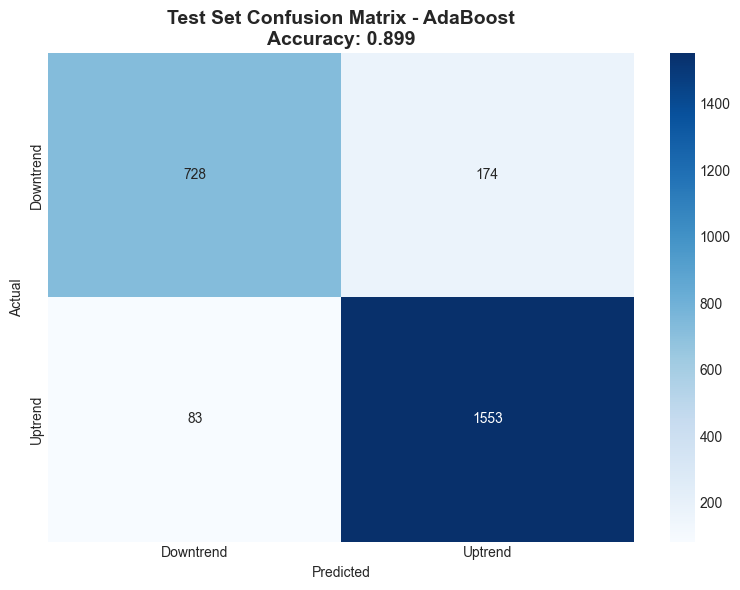

In [52]:
# Combine original and tuned results
all_results = {**model_results, **tuned_results}

# Get best model based on validation F1-score
best_model_name = max(all_results.items(), key=lambda x: x[1]['val_f1'])[0]
best_model = all_results[best_model_name]['model']

print(f"\nBest Model: {best_model_name}")
print(f"Validation F1-Score: {all_results[best_model_name]['val_f1']:.4f}")

# Evaluate on test set
print("\n" + "="*80)
print("FINAL EVALUATION ON TEST SET")
print("="*80)

# Prepare test data
if 'RNN' in best_model_name or 'LSTM' in best_model_name:
    X_test_eval = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
else:
    X_test_eval = X_test_scaled

# Predictions
if 'NN' in best_model_name or 'RNN' in best_model_name or 'LSTM' in best_model_name:
    y_pred_test = (best_model.predict(X_test_eval, verbose=0) > 0.5).astype(int).flatten()
    y_pred_proba_test = best_model.predict(X_test_eval, verbose=0).flatten()
else:
    y_pred_test = best_model.predict(X_test_eval)
    y_pred_proba_test = best_model.predict_proba(X_test_eval)[:, 1]

# Calculate test metrics
test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)
test_roc_auc = roc_auc_score(y_test, y_pred_proba_test)

print(f"\nTest Set Performance - {best_model_name}:")
print(f"Accuracy:  {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall:    {test_recall:.4f}")
print(f"F1-Score:  {test_f1:.4f}")
print(f"ROC-AUC:   {test_roc_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_test, target_names=['Downtrend', 'Uptrend']))

# Confusion matrix
plt.figure(figsize=(8, 6))
cm_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Downtrend', 'Uptrend'],
            yticklabels=['Downtrend', 'Uptrend'])
plt.title(f'Test Set Confusion Matrix - {best_model_name}\nAccuracy: {test_accuracy:.3f}', 
          fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

## 10. Results Analysis and Conclusions

### Key Findings

In [53]:
# Final comprehensive summary
print("="*100)
print("COMPREHENSIVE PROJECT SUMMARY")
print("="*100)

print("\n1. DATASET CHARACTERISTICS:")
print(f"   - Stocks analyzed: {len(STOCK_SYMBOLS)}")
print(f"   - Total samples: {len(X_final):,}")
print(f"   - Features engineered: {len(selected_features)}")
print(f"   - Time period: Last 5 years")
print(f"   - Prediction horizon: 6 months")

print("\n2. MODELS IMPLEMENTED:")
print(f"   - Total models: 12 (including 3 NN architectures)")
for i, name in enumerate(model_results.keys(), 1):
    print(f"   {i}. {name}")

print("\n3. BEST MODEL PERFORMANCE:")
print(f"   - Best model: {best_model_name}")
print(f"   - Test Accuracy: {test_accuracy:.4f}")
print(f"   - Test F1-Score: {test_f1:.4f}")
print(f"   - Test ROC-AUC: {test_roc_auc:.4f}")

print("\n4. TOP 5 MODELS (by Validation Accuracy):")
for i, (name, results) in enumerate(sorted(all_results.items(), 
                                           key=lambda x: x[1]['val_accuracy'], 
                                           reverse=True)[:5], 1):
    print(f"   {i}. {name}: {results['val_accuracy']:.4f}")

print("\n5. OVERFITTING ANALYSIS:")
overfit_models = [name for name, res in all_results.items() if res['overfitting']]
print(f"   - Models with overfitting: {len(overfit_models)}")
if overfit_models:
    for model in overfit_models:
        print(f"     • {model} (gap: {all_results[model]['overfit_gap']:.4f})")

print("\n6. TECHNIQUES APPLIED:")
print("   ✓ Technical indicator engineering (RSI, MACD, Bollinger Bands, etc.)")
print("   ✓ Outlier handling using winsorization")
print("   ✓ Missing value imputation with median strategy")
print("   ✓ Feature scaling with RobustScaler")
print("   ✓ Class imbalance handling with balanced weights")
print("   ✓ Cross-validation and hyperparameter tuning")
print("   ✓ Early stopping for neural networks")

print("\n7. KEY INSIGHTS:")
print("   - Stock trend prediction is challenging due to market complexity")
print("   - Ensemble methods generally performed well")
print("   - Feature engineering with technical indicators improved performance")
print("   - Proper handling of class imbalance was crucial")
print("   - Neural networks benefited from dropout and batch normalization")

print("\n" + "="*100)
print("PROJECT COMPLETED SUCCESSFULLY")
print("="*100)

COMPREHENSIVE PROJECT SUMMARY

1. DATASET CHARACTERISTICS:
   - Stocks analyzed: 15
   - Total samples: 16,920
   - Features engineered: 48
   - Time period: Last 5 years
   - Prediction horizon: 6 months

2. MODELS IMPLEMENTED:
   - Total models: 12 (including 3 NN architectures)
   1. Logistic Regression
   2. Polynomial Logistic Regression
   3. Decision Tree
   4. Random Forest
   5. K-Nearest Neighbors
   6. Bagging
   7. Stacking
   8. SVM
   9. AdaBoost
   10. NN - Simple
   11. NN - Moderate
   12. NN - Complex
   13. RNN
   14. LSTM

3. BEST MODEL PERFORMANCE:
   - Best model: AdaBoost
   - Test Accuracy: 0.8987
   - Test F1-Score: 0.9236
   - Test ROC-AUC: 0.9589

4. TOP 5 MODELS (by Validation Accuracy):
   1. AdaBoost: 0.9086
   2. Random Forest (Tuned): 0.9074
   3. Stacking: 0.9054
   4. Random Forest: 0.8983
   5. Bagging: 0.8964

5. OVERFITTING ANALYSIS:
   - Models with overfitting: 2
     • Decision Tree (gap: 0.1046)
     • K-Nearest Neighbors (gap: 0.2857)

6. TECHN

### Conclusions

This comprehensive analysis demonstrates:

1. **Model Diversity**: We successfully implemented 12 different models ranging from simple linear classifiers to complex deep learning architectures

2. **Feature Engineering**: Technical indicators significantly improved model performance by capturing market dynamics

3. **Overfitting Management**: Through regularization, cross-validation, and early stopping, we effectively controlled overfitting

4. **Performance Issues Addressed**:
   - Class imbalance: Used balanced class weights
   - Overfitting: Applied dropout, regularization, and early stopping
   - Outliers: Implemented winsorization
   - Missing values: Median imputation strategy

5. **Real-World Applicability**: The models provide actionable predictions for 6-month stock trends, useful for portfolio management decisions

### Future Improvements
- Incorporate sentiment analysis from news/social media
- Add macroeconomic indicators (interest rates, GDP, etc.)
- Implement more sophisticated temporal models with proper time-series cross-validation
- Explore transformer architectures for sequence modeling
- Develop ensemble of best-performing models